# Temperature Forecast Project using ML


This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.

TARGET-You have to build separate models that can predict the minimum temperature for the next day and the maximum temperature for the next day based on the details provided in the dataset.

Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import zscore
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [3]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier,GradientBoostingRegressor,ExtraTreesClassifier,ExtraTreesRegressor,AdaBoostClassifier,AdaBoostRegressor,BaggingClassifier,BaggingRegressor
from sklearn.metrics import RocCurveDisplay,roc_auc_score,accuracy_score,mean_absolute_error,mean_squared_error, r2_score, classification_report, confusion_matrix,auc, roc_curve
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso,Ridge
from sklearn.svm import SVC,SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor


DATA COLLECTION

In [4]:
df=pd.read_csv('temperature.csv')
df.head()

station        Date  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
0      1.0  30-06-2013          28.7          21.4    58.255688    91.116364   
1      2.0  30-06-2013          31.9          21.6    52.263397    90.604721   
2      3.0  30-06-2013          31.6          23.3    48.690479    83.973587   
3      4.0  30-06-2013          32.0          23.4    58.239788    96.483688   
4      5.0  30-06-2013          31.4          21.9    56.174095    90.155128   

   LDAPS_Tmax_lapse  LDAPS_Tmin_lapse  LDAPS_WS    LDAPS_LH  ...  LDAPS_PPT2  \
0         28.074101         23.006936  6.818887   69.451805  ...         0.0   
1         29.850689         24.035009  5.691890   51.937448  ...         0.0   
2         30.091292         24.565633  6.138224   20.573050  ...         0.0   
3         29.704629         23.326177  5.650050   65.727144  ...         0.0   
4         29.113934         23.486480  5.735004  107.965535  ...         0.0   

   LDAPS_PPT3  LDAPS_PPT4      lat      lon       DEM   Slope  \
0         0.0         0.0  37.6046  126.991  212.3350  2.7850   
1         0.0         0.0  37.6046  127.032   44.7624  0.5141   
2         0.0         0.0  37.5776  127.058   33.3068  0.2661   
3         0.0         0.0  37.6450  127.022   45.7160  2.5348   
4         0.0         0.0  37.5507  127.135   35.0380  0.5055   

   Solar radiation  Next_Tmax  Next_Tmin  
0      5992.895996       29.1       21.2  
1      5869.312500       30.5       22.5  
2      5863.555664       31.1       23.9  
3      5856.964844       31.7       24.3  
4      5859.552246       31.2       22.5  

[5 rows x 25 columns]

In [5]:
df.tail()

station        Date  Present_Tmax  Present_Tmin  LDAPS_RHmin  \
7747     23.0  30-08-2017          23.3          17.1    26.741310   
7748     24.0  30-08-2017          23.3          17.7    24.040634   
7749     25.0  30-08-2017          23.2          17.4    22.933014   
7750      NaN         NaN          20.0          11.3    19.794666   
7751      NaN         NaN          37.6          29.9    98.524734   

      LDAPS_RHmax  LDAPS_Tmax_lapse  LDAPS_Tmin_lapse   LDAPS_WS    LDAPS_LH  \
7747    78.869858         26.352081         18.775678   6.148918   72.058294   
7748    77.294975         27.010193         18.733519   6.542819   47.241457   
7749    77.243744         27.939516         18.522965   7.289264    9.090034   
7750    58.936283         17.624954         14.272646   2.882580  -13.603212   
7751   100.000153         38.542255         29.619342  21.857621  213.414006   

      ...  LDAPS_PPT2  LDAPS_PPT3  LDAPS_PPT4      lat      lon       DEM  \
7747  ...    0.000000    0.000000    0.000000  37.5372  126.891   15.5876   
7748  ...    0.000000    0.000000    0.000000  37.5237  126.909   17.2956   
7749  ...    0.000000    0.000000    0.000000  37.5237  126.970   19.5844   
7750  ...    0.000000    0.000000    0.000000  37.4562  126.826   12.3700   
7751  ...   21.621661   15.841235   16.655469  37.6450  127.135  212.3350   

         Slope  Solar radiation  Next_Tmax  Next_Tmin  
7747  0.155400      4443.313965       28.3       18.1  
7748  0.222300      4438.373535       28.6       18.8  
7749  0.271300      4451.345215       27.8       17.4  
7750  0.098475      4329.520508       17.4       11.3  
7751  5.178230      5992.895996       38.9       29.8  

[5 rows x 25 columns]

DATA UNDERSTANDING !!

In [6]:
df.shape

(7752, 25)

In [7]:
df.columns

Index(['station', 'Date', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin',
       'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS',
       'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4',
       'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon',
       'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


we observe that data is continuing

In [9]:
df['station'].iloc[7750] = 1.0
df['station'].iloc[7751] = 2.0
df['Date'].iloc[7750] = '31-08-2017'
df['Date'].iloc[7751] = '31-08-2017'

In [10]:
ccol = df.select_dtypes(include=['object']).columns
print("Categorical columns are:",ccol)
print("\n")

ncol = df.select_dtypes(include=['int64','float64']).columns
print("Numerical columns are:",ncol)

Categorical columns are: Index(['Date'], dtype='object')


Numerical columns are: Index(['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope',
       'Solar radiation', 'Next_Tmax', 'Next_Tmin'],
      dtype='object')


expect date, all are in float data type

In [11]:
df["Date"] = pd.to_datetime(df["Date"])
print("Minimum date:", df["Date"].min())
print("Maximum date:", df["Date"].max())

Minimum date: 2013-06-30 00:00:00
Maximum date: 2017-08-31 00:00:00


In [12]:
df['Day']=df['Date'].apply(lambda x:x.day)
df['Month']=df['Date'].apply(lambda x:x.month)
df['Year']=df['Date'].apply(lambda x:x.year)
df.head(2)

station       Date  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
0      1.0 2013-06-30          28.7          21.4    58.255688    91.116364   
1      2.0 2013-06-30          31.9          21.6    52.263397    90.604721   

   LDAPS_Tmax_lapse  LDAPS_Tmin_lapse  LDAPS_WS   LDAPS_LH  ...      lat  \
0         28.074101         23.006936  6.818887  69.451805  ...  37.6046   
1         29.850689         24.035009  5.691890  51.937448  ...  37.6046   

       lon       DEM   Slope  Solar radiation  Next_Tmax  Next_Tmin  Day  \
0  126.991  212.3350  2.7850      5992.895996       29.1       21.2   30   
1  127.032   44.7624  0.5141      5869.312500       30.5       22.5   30   

   Month  Year  
0      6  2013  
1      6  2013  

[2 rows x 28 columns]

In [13]:
df.drop('Date', axis=1, inplace = True)
df.shape

(7752, 27)

Location is not prioritized for time target

In [14]:
df.drop(columns = ['lat','lon'], inplace = True)

Duplicate Values in our Dataframe

In [15]:
print(" ", df.duplicated().sum())

  0


<Axes: >

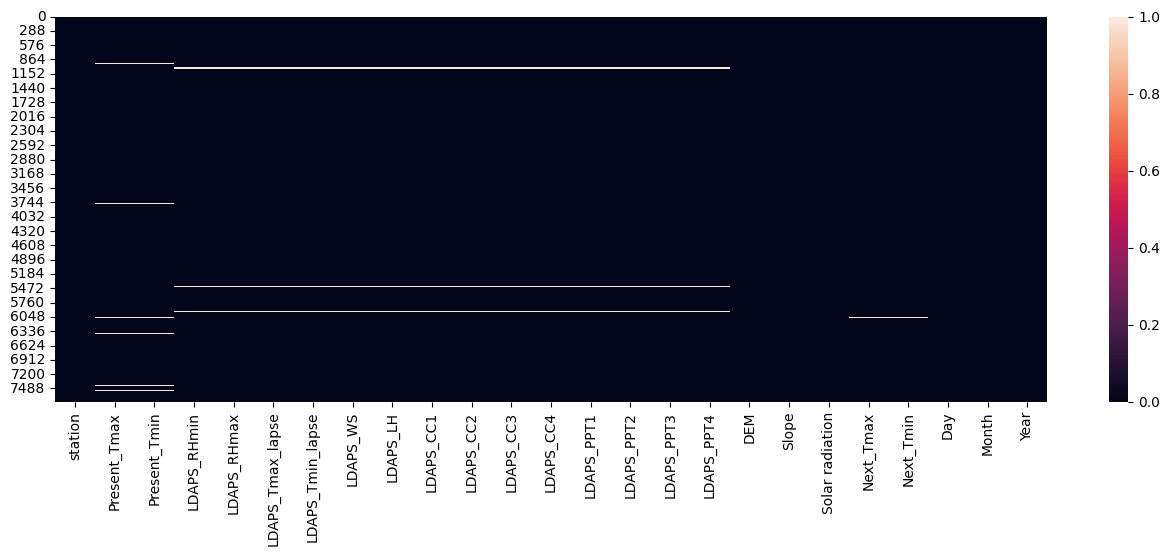

In [16]:
plt.figure(figsize = (16,5))
sns.heatmap(df.isnull())

In [17]:
df.isnull().sum()

station              0
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
Day                  0
Month                0
Year                 0
dtype: int64

In [18]:
df = df.apply(lambda col: col.fillna(col.mean()) if col.name not in ['station', 'date'] else col)

In [19]:
df.isnull().sum()

station             0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
Day                 0
Month               0
Year                0
dtype: int64

In [20]:
df.describe().T

count         mean         std          min          25%  \
station           7752.0    12.997033    7.213007     1.000000     7.000000   
Present_Tmax      7752.0    29.768211    2.956557    20.000000    27.800000   
Present_Tmin      7752.0    23.225059    2.403036    11.300000    21.700000   
LDAPS_RHmin       7752.0    56.759372   14.596973    19.794666    46.046162   
LDAPS_RHmax       7752.0    88.374804    7.157124    58.936283    84.316923   
LDAPS_Tmax_lapse  7752.0    29.613447    2.932898    17.624954    27.693091   
LDAPS_Tmin_lapse  7752.0    23.512589    2.333973    14.272646    22.114651   
LDAPS_WS          7752.0     7.097875    2.173245     2.882580     5.686487   
LDAPS_LH          7752.0    62.505019   33.567001   -13.603212    37.532764   
LDAPS_CC1         7752.0     0.368774    0.261185     0.000000     0.148321   
LDAPS_CC2         7752.0     0.356080    0.256810     0.000000     0.142328   
LDAPS_CC3         7752.0     0.318404    0.249148     0.000000     0.103100   
LDAPS_CC4         7752.0     0.299191    0.253114     0.000000     0.082741   
LDAPS_PPT1        7752.0     0.591995    1.936331     0.000000     0.000000   
LDAPS_PPT2        7752.0     0.485003    1.754258     0.000000     0.000000   
LDAPS_PPT3        7752.0     0.278200    1.156174     0.000000     0.000000   
LDAPS_PPT4        7752.0     0.269407    1.200364     0.000000     0.000000   
DEM               7752.0    61.867972   54.279780    12.370000    28.700000   
Slope             7752.0     1.257048    1.370444     0.098475     0.271300   
Solar radiation   7752.0  5341.502803  429.158867  4329.520508  4999.018555   
Next_Tmax         7752.0    30.274887    3.122557    17.400000    28.200000   
Next_Tmin         7752.0    22.932220    2.483276    11.300000    21.400000   
Day               7752.0    15.987745    8.920757     1.000000     8.000000   
Month             7752.0     7.467879    0.530334     6.000000     7.000000   
Year              7752.0  2015.000516    1.414487  2013.000000  2014.000000   

                          50%          75%          max  
station             13.000000    19.000000    25.000000  
Present_Tmax        29.900000    32.000000    37.600000  
Present_Tmin        23.400000    24.900000    29.900000  
LDAPS_RHmin         55.313244    67.038254    98.524734  
LDAPS_RHmax         89.699505    93.704500   100.000153  
LDAPS_Tmax_lapse    29.662273    31.683819    38.542255  
LDAPS_Tmin_lapse    23.735942    25.134000    29.619342  
LDAPS_WS             6.563068     8.007471    21.857621  
LDAPS_LH            57.310630    83.904586   213.414006  
LDAPS_CC1            0.320110     0.571696     0.967277  
LDAPS_CC2            0.315667     0.554963     0.968353  
LDAPS_CC3            0.265264     0.494007     0.983789  
LDAPS_CC4            0.232354     0.497230     0.974710  
LDAPS_PPT1           0.000000     0.067593    23.701544  
LDAPS_PPT2           0.000000     0.024276    21.621661  
LDAPS_PPT3           0.000000     0.009697    15.841235  
LDAPS_PPT4           0.000000     0.000693    16.655469  
DEM                 45.716000    59.832400   212.335000  
Slope                0.618000     1.767800     5.178230  
Solar radiation   5436.345215  5728.316406  5992.895996  
Next_Tmax           30.500000    32.600000    38.900000  
Next_Tmin           23.100000    24.600000    29.800000  
Day                 16.000000    24.000000    31.000000  
Month                7.000000     8.000000     8.000000  
Year              2015.000000  2016.000000  2017.000000

observation

# EDA

UNIVARIENT-ANALYSIS

In [21]:
df.nunique()

station               25
Present_Tmax         168
Present_Tmin         156
LDAPS_RHmin         7673
LDAPS_RHmax         7665
LDAPS_Tmax_lapse    7676
LDAPS_Tmin_lapse    7676
LDAPS_WS            7676
LDAPS_LH            7676
LDAPS_CC1           7570
LDAPS_CC2           7583
LDAPS_CC3           7600
LDAPS_CC4           7525
LDAPS_PPT1          2813
LDAPS_PPT2          2511
LDAPS_PPT3          2357
LDAPS_PPT4          1919
DEM                   25
Slope                 27
Solar radiation     1575
Next_Tmax            184
Next_Tmin            158
Day                   31
Month                  3
Year                   5
dtype: int64

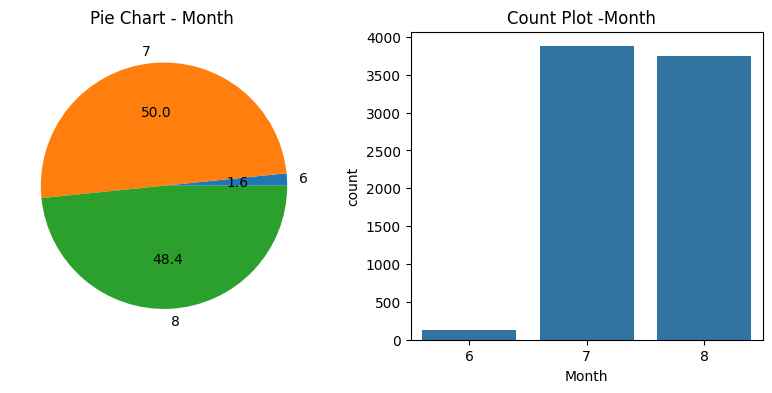

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df.groupby('Month').size().plot(kind='pie', autopct='%.1f', ax=axes[0])
axes[0].set_title('Pie Chart - Month ')

sns.countplot(x='Month', data=df, ax=axes[1])
axes[1].set_title('Count Plot -Month  ')

plt.show()

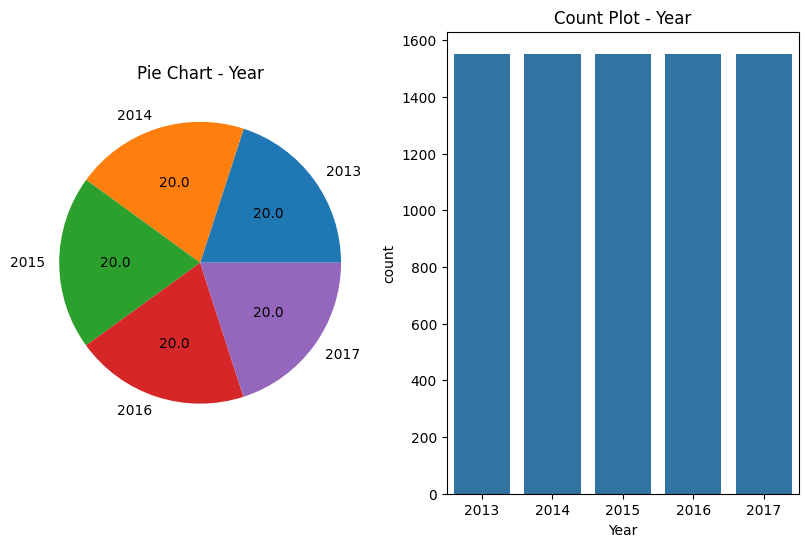

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
df.groupby('Year').size().plot(kind='pie', autopct='%.1f', ax=axes[0])
axes[0].set_title('Pie Chart - Year')

sns.countplot(x='Year', data=df, ax=axes[1])
axes[1].set_title('Count Plot - Year')

plt.show()

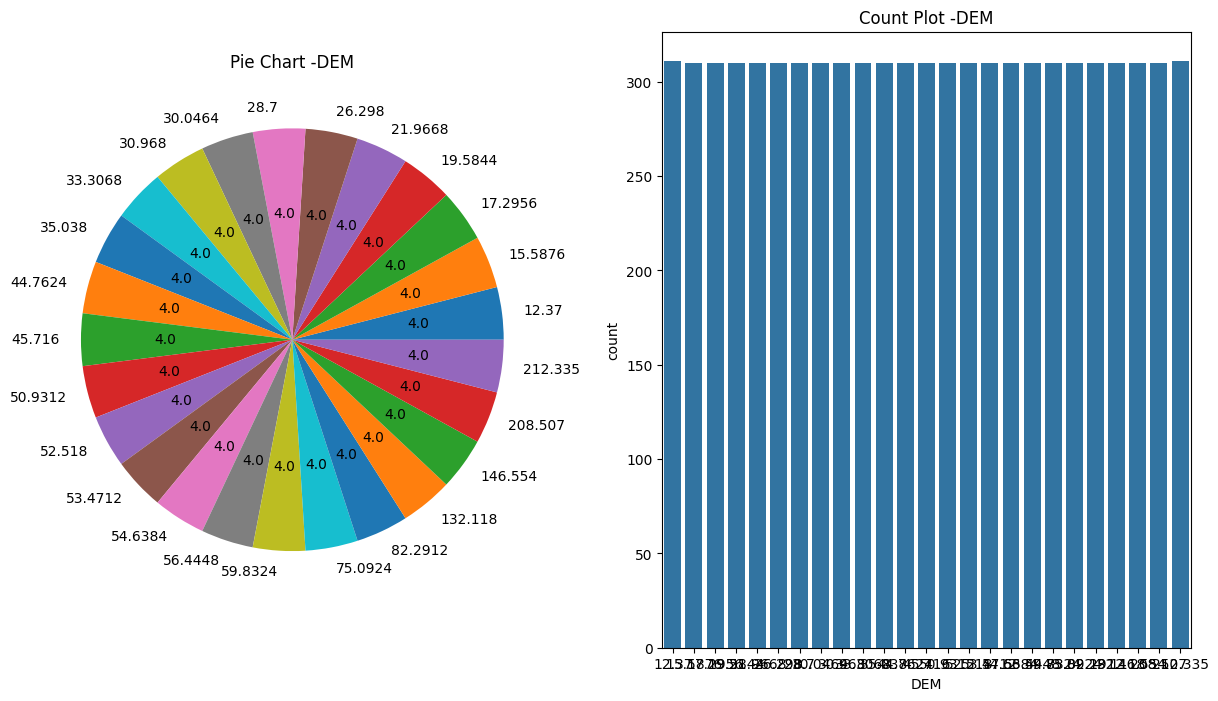

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
df.groupby('DEM').size().plot(kind='pie', autopct='%.1f', ax=axes[0])
axes[0].set_title('Pie Chart -DEM')

sns.countplot(x='DEM', data=df, ax=axes[1])
axes[1].set_title('Count Plot -DEM')

plt.show()

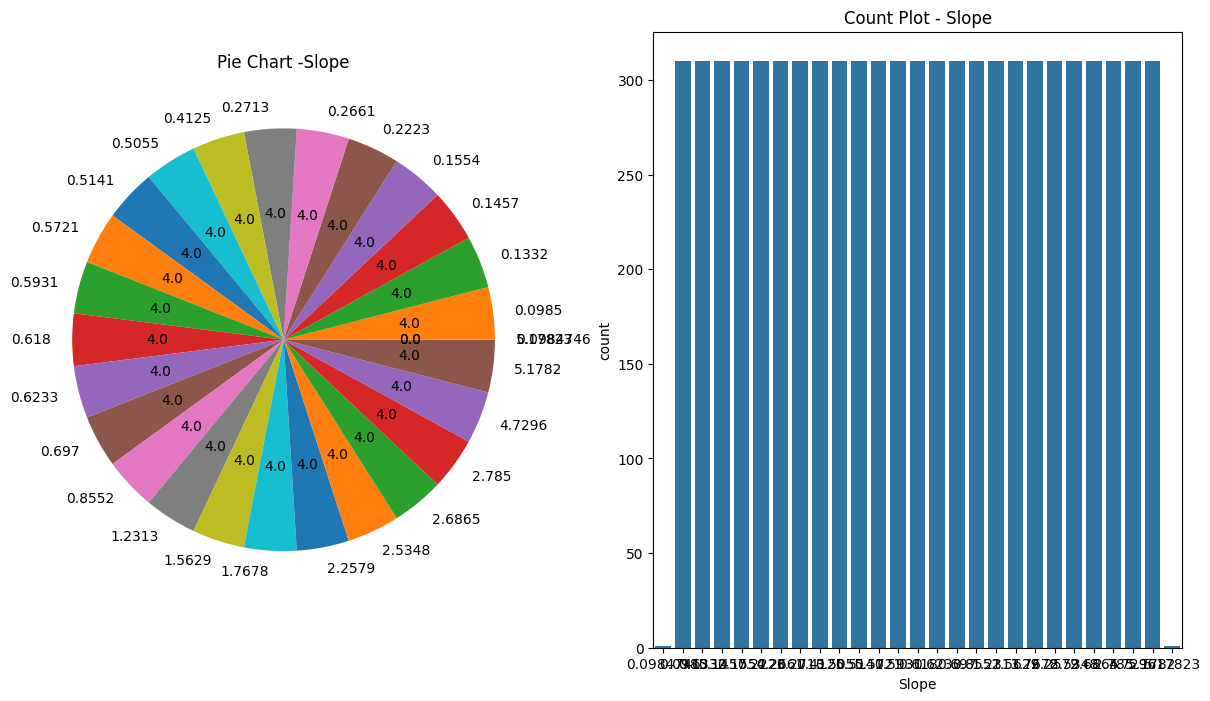

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
df.groupby('Slope').size().plot(kind='pie', autopct='%.1f', ax=axes[0])
axes[0].set_title('Pie Chart -Slope')

sns.countplot(x='Slope', data=df, ax=axes[1])
axes[1].set_title('Count Plot - Slope')

plt.show()

BI-varient analysis

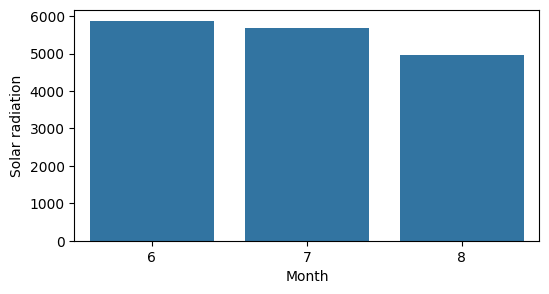

In [26]:
plt.figure(figsize=(6,3))
sns.barplot(x=df['Month'], y=df['Solar radiation'])
plt.show()

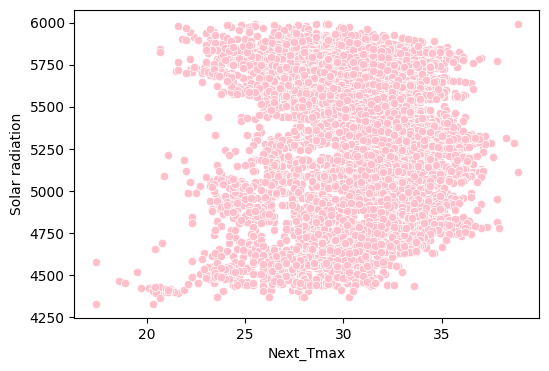

In [27]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='Next_Tmax', y='Solar radiation', data=df, color='pink')
plt.show()

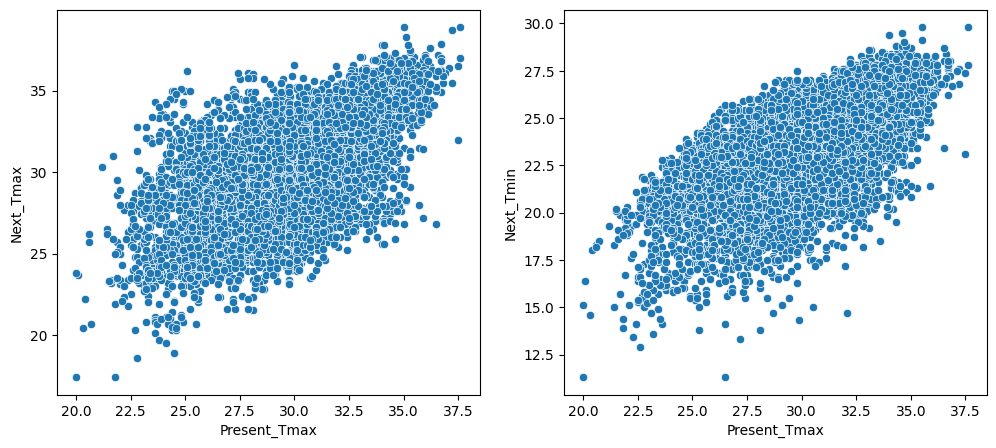

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'Present_Tmax', y = 'Next_Tmax', data = df)
plt.subplot(1, 2, 2)
sns.scatterplot(x = 'Present_Tmax', y = 'Next_Tmin', data = df)
plt.show()

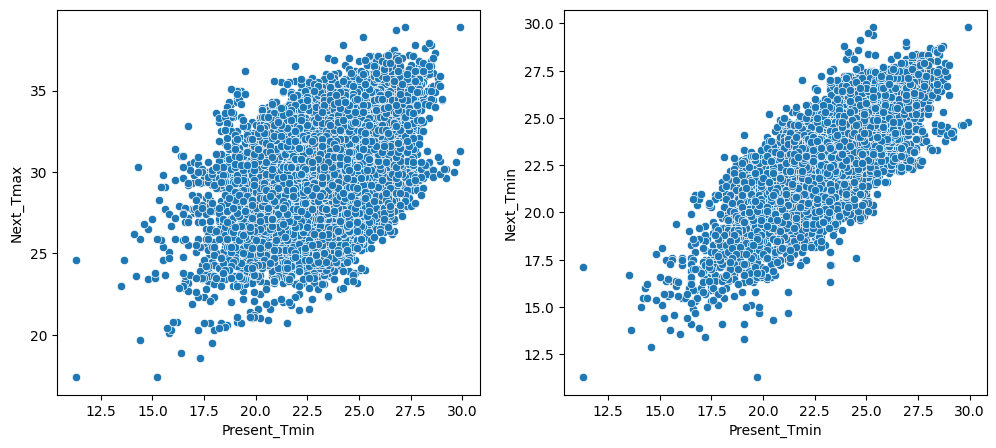

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'Present_Tmin', y = 'Next_Tmax', data = df)
plt.subplot(1, 2, 2)
sns.scatterplot(x = 'Present_Tmin', y = 'Next_Tmin', data = df)
plt.show()

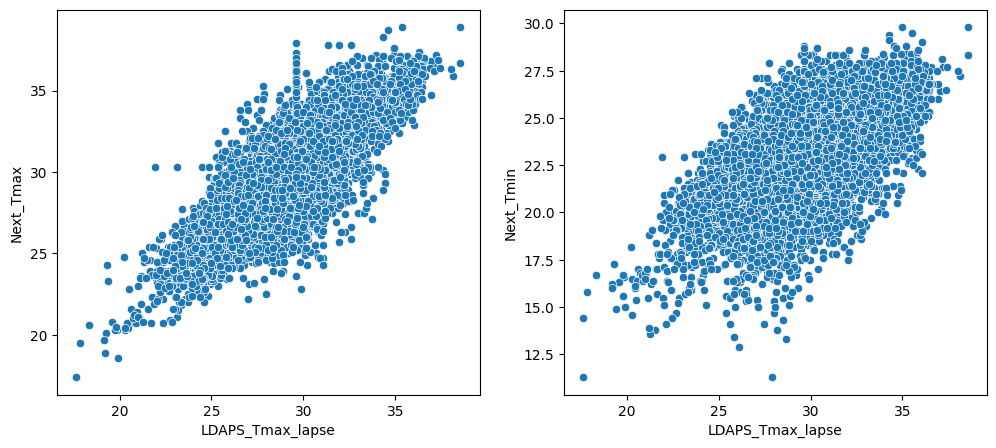

In [30]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'LDAPS_Tmax_lapse', y = 'Next_Tmax', data = df)
plt.subplot(1, 2, 2)
sns.scatterplot(x = 'LDAPS_Tmax_lapse', y = 'Next_Tmin', data = df)
plt.show()

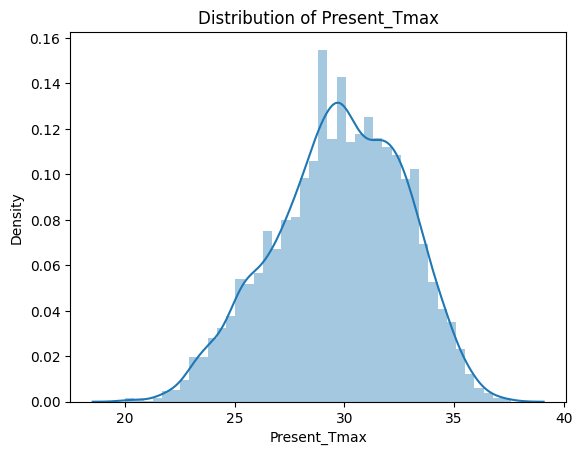

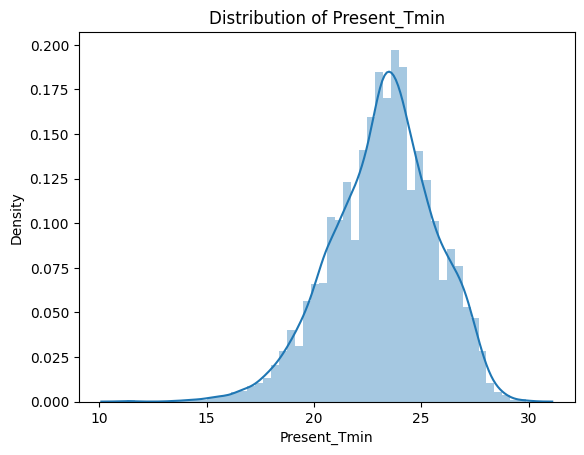

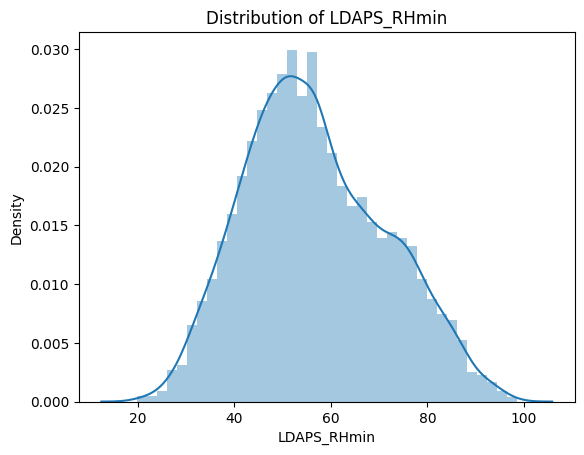

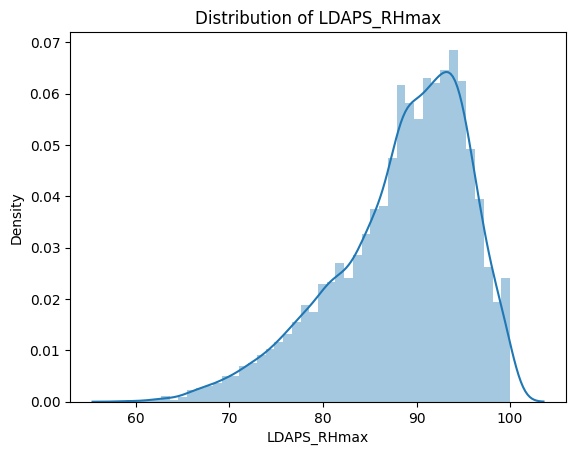

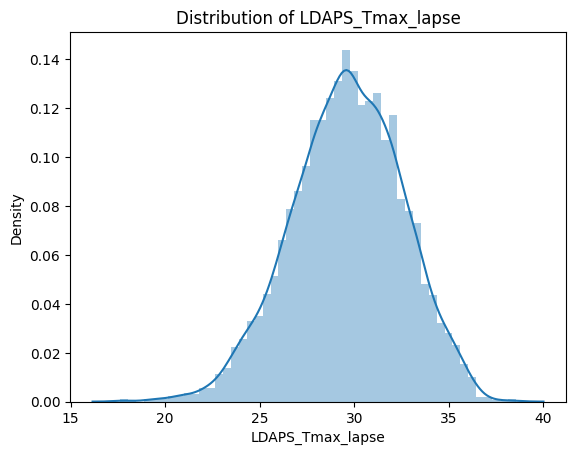

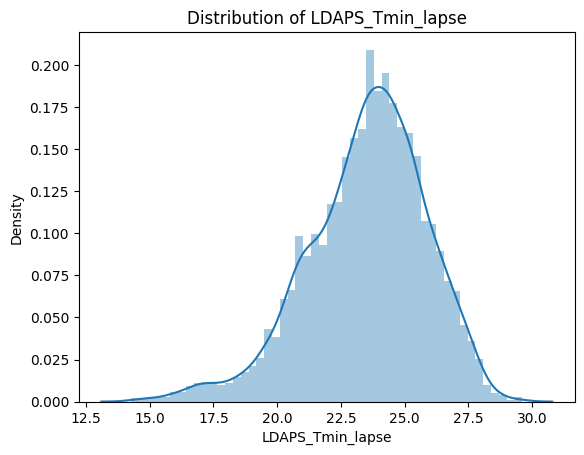

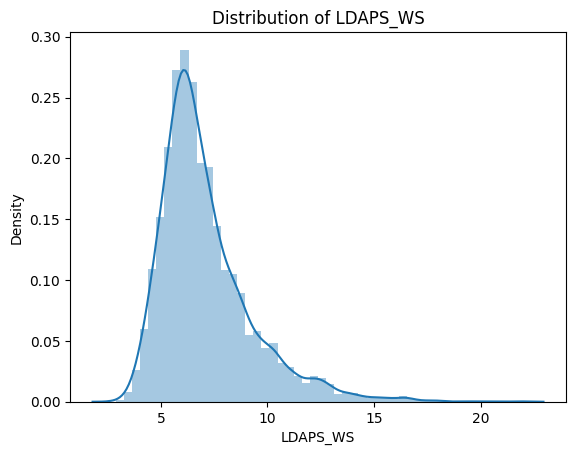

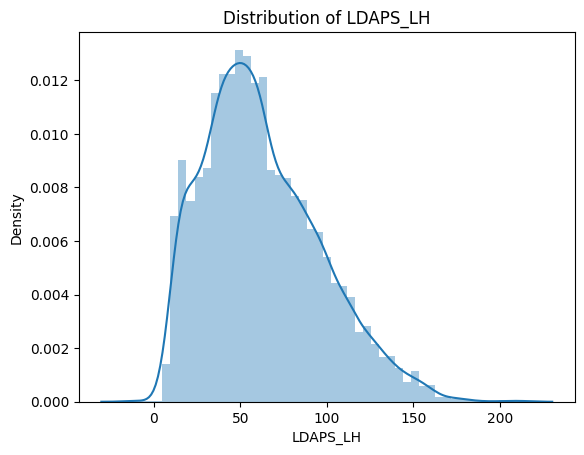

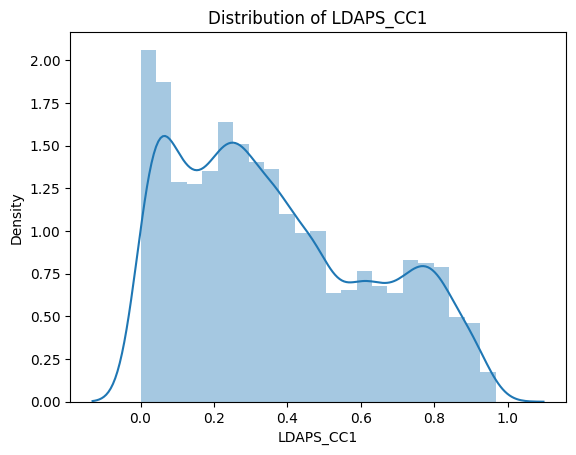

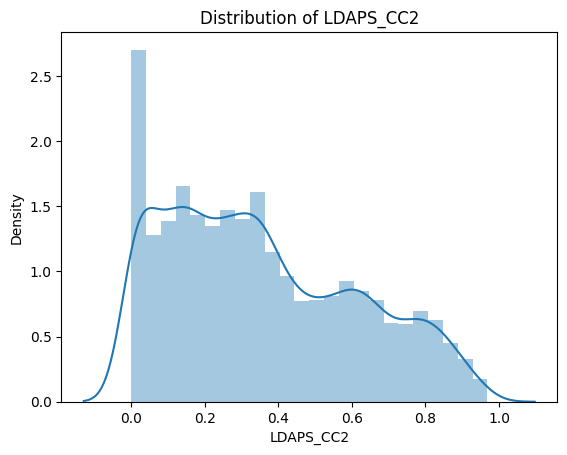

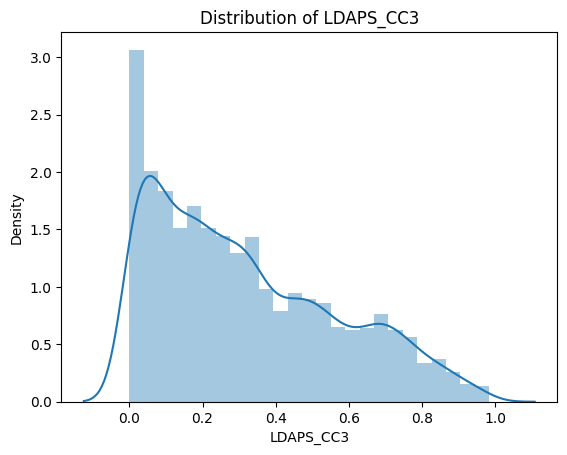

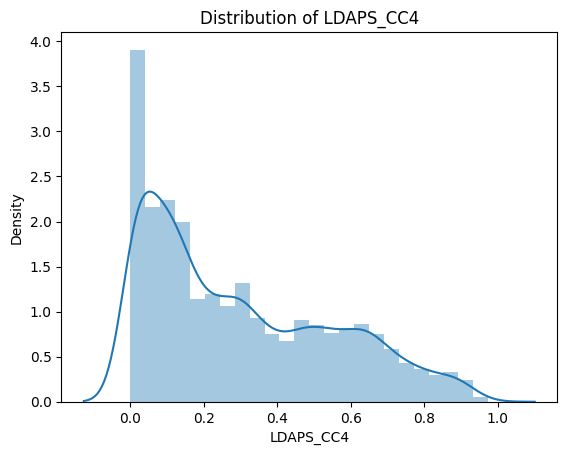

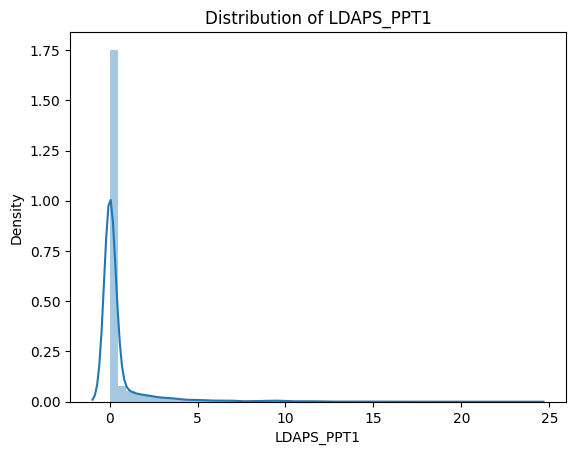

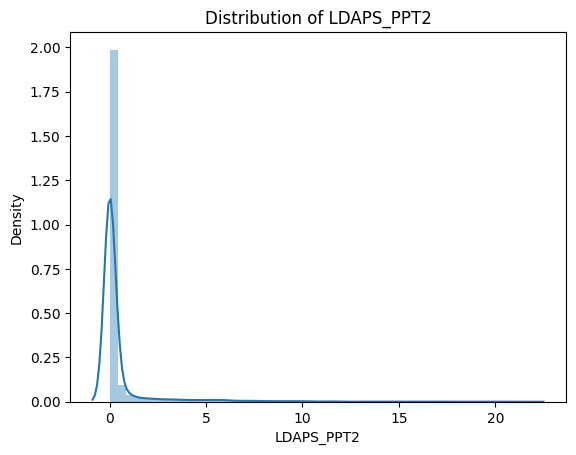

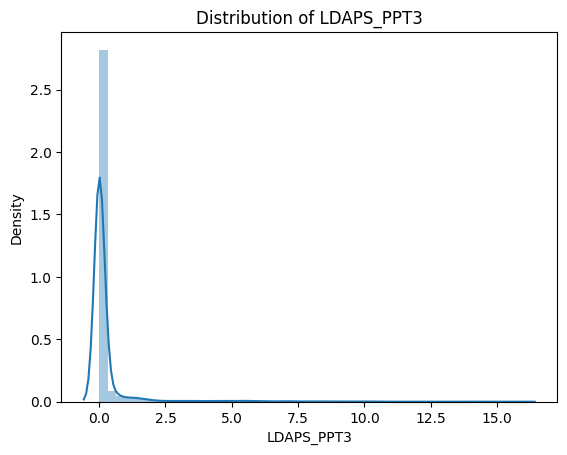

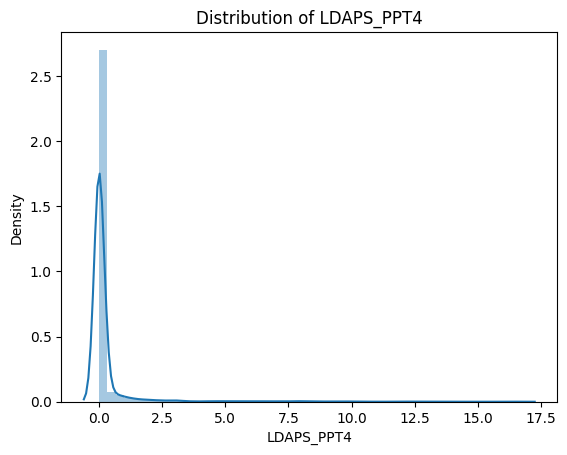

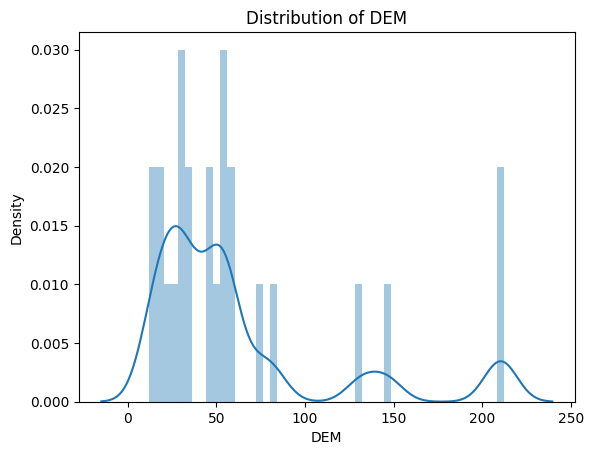

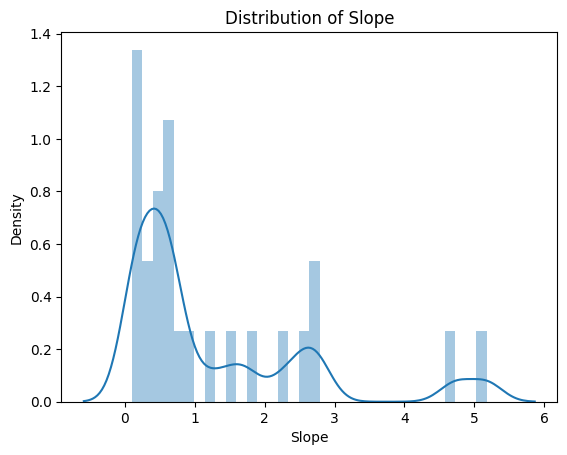

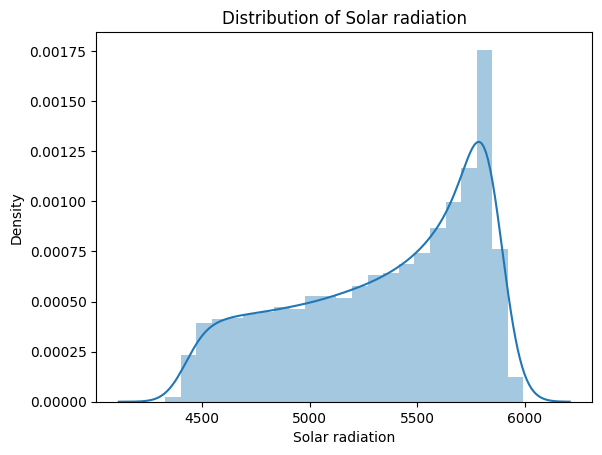

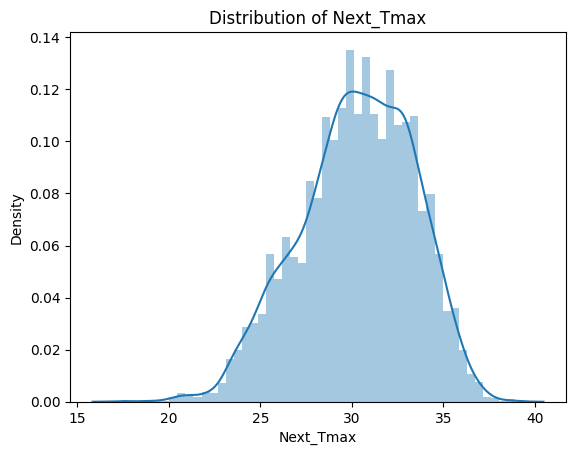

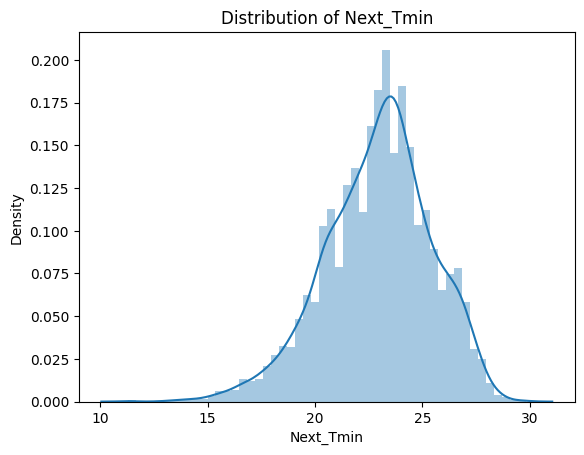

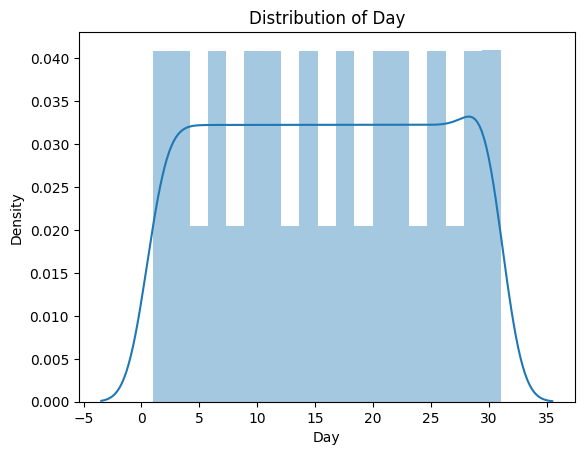

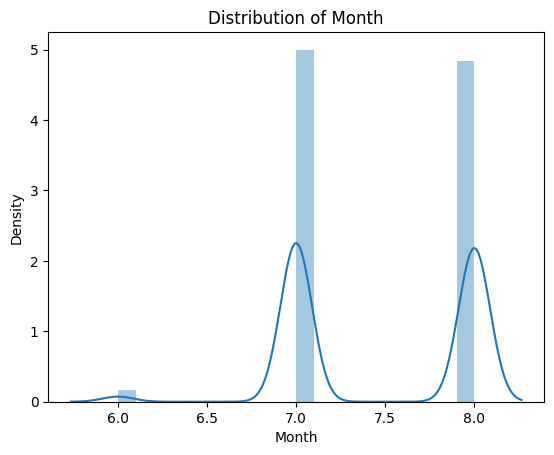

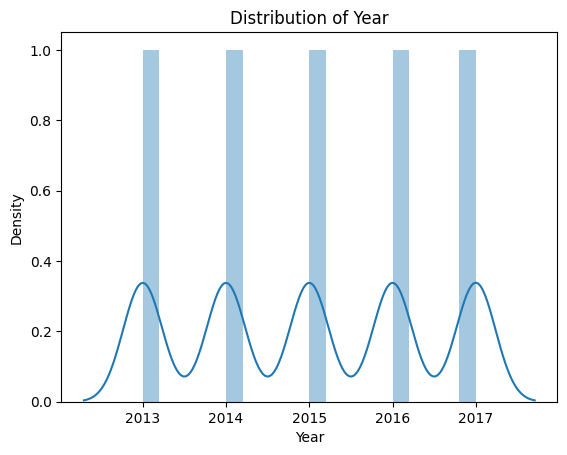

In [31]:
for col in df.columns:
    if col not in ['station', 'date']:
        sns.distplot(df[col])
        plt.title(f'Distribution of {col}')
        plt.show()

Multi-Variate Analysis

FINDING DATA CORRELATION

In [32]:
df.corr()

station  Present_Tmax  Present_Tmin  LDAPS_RHmin  \
station           1.000000      0.112806      0.132122    -0.066731   
Present_Tmax      0.112806      1.000000      0.618760    -0.204571   
Present_Tmin      0.132122      0.618760      1.000000     0.123143   
LDAPS_RHmin      -0.066731     -0.204571      0.123143     1.000000   
LDAPS_RHmax      -0.166366     -0.301787     -0.015140     0.579141   
LDAPS_Tmax_lapse  0.069363      0.570129      0.464151    -0.564580   
LDAPS_Tmin_lapse  0.105059      0.623496      0.762993     0.089476   
LDAPS_WS          0.004355     -0.121820     -0.034675     0.294361   
LDAPS_LH         -0.133711      0.135463     -0.009258    -0.070858   
LDAPS_CC1         0.006769     -0.311805      0.084447     0.613818   
LDAPS_CC2         0.003223     -0.213791      0.090263     0.745443   
LDAPS_CC3         0.000443     -0.144018     -0.002772     0.689679   
LDAPS_CC4         0.005853     -0.140729     -0.044335     0.514075   
LDAPS_PPT1       -0.004991     -0.109006      0.112845     0.262665   
LDAPS_PPT2       -0.010558     -0.099449      0.068176     0.390967   
LDAPS_PPT3       -0.015054     -0.120367     -0.046126     0.240642   
LDAPS_PPT4       -0.013036     -0.099607     -0.062965     0.168595   
DEM              -0.256095     -0.187121     -0.250275     0.102115   
Slope            -0.090413     -0.105809     -0.146339     0.123744   
Solar radiation  -0.018787     -0.025439      0.053578     0.244080   
Next_Tmax         0.108289      0.610348      0.471806    -0.437898   
Next_Tmin         0.128713      0.622741      0.796670     0.095019   
Day              -0.000692     -0.141944     -0.106539    -0.063041   
Month            -0.000413      0.145849      0.087021    -0.188938   
Year             -0.000582      0.059665      0.036987    -0.001984   

                  LDAPS_RHmax  LDAPS_Tmax_lapse  LDAPS_Tmin_lapse  LDAPS_WS  \
station             -0.166366          0.069363          0.105059  0.004355   
Present_Tmax        -0.301787          0.570129          0.623496 -0.121820   
Present_Tmin        -0.015140          0.464151          0.762993 -0.034675   
LDAPS_RHmin          0.579141         -0.564580          0.089476  0.294361   
LDAPS_RHmax          1.000000         -0.373404         -0.114143  0.135333   
LDAPS_Tmax_lapse    -0.373404          1.000000          0.654021 -0.311996   
LDAPS_Tmin_lapse    -0.114143          0.654021          1.000000 -0.130035   
LDAPS_WS             0.135333         -0.311996         -0.130035  1.000000   
LDAPS_LH             0.238579          0.048010         -0.134761  0.006711   
LDAPS_CC1            0.436652         -0.438439          0.010901  0.289445   
LDAPS_CC2            0.391330         -0.523619          0.047727  0.261090   
LDAPS_CC3            0.226957         -0.541327         -0.044018  0.242991   
LDAPS_CC4            0.130619         -0.429539         -0.080335  0.220533   
LDAPS_PPT1           0.268449         -0.111065          0.038056  0.152587   
LDAPS_PPT2           0.229050         -0.242122          0.000870  0.191886   
LDAPS_PPT3           0.134607         -0.188115         -0.088575  0.161684   
LDAPS_PPT4           0.117853         -0.160273         -0.094655  0.144085   
DEM                  0.177168         -0.178895         -0.195455  0.191053   
Slope                0.219599         -0.162332         -0.185849  0.171629   
Solar radiation      0.149261          0.047971          0.159975  0.121759   
Next_Tmax           -0.283738          0.827189          0.586983 -0.342729   
Next_Tmin           -0.071997          0.586868          0.880176 -0.096576   
Day                 -0.015585         -0.159546         -0.172960 -0.039619   
Month               -0.118116          0.097194          0.023211 -0.110944   
Year                -0.142249          0.015978         -0.004937 -0.110444   

                  LDAPS_LH  LDAPS_CC1  ...  LDAPS_PPT3  LDAPS_PPT4       DEM  \
station          -0.133711   0.006769

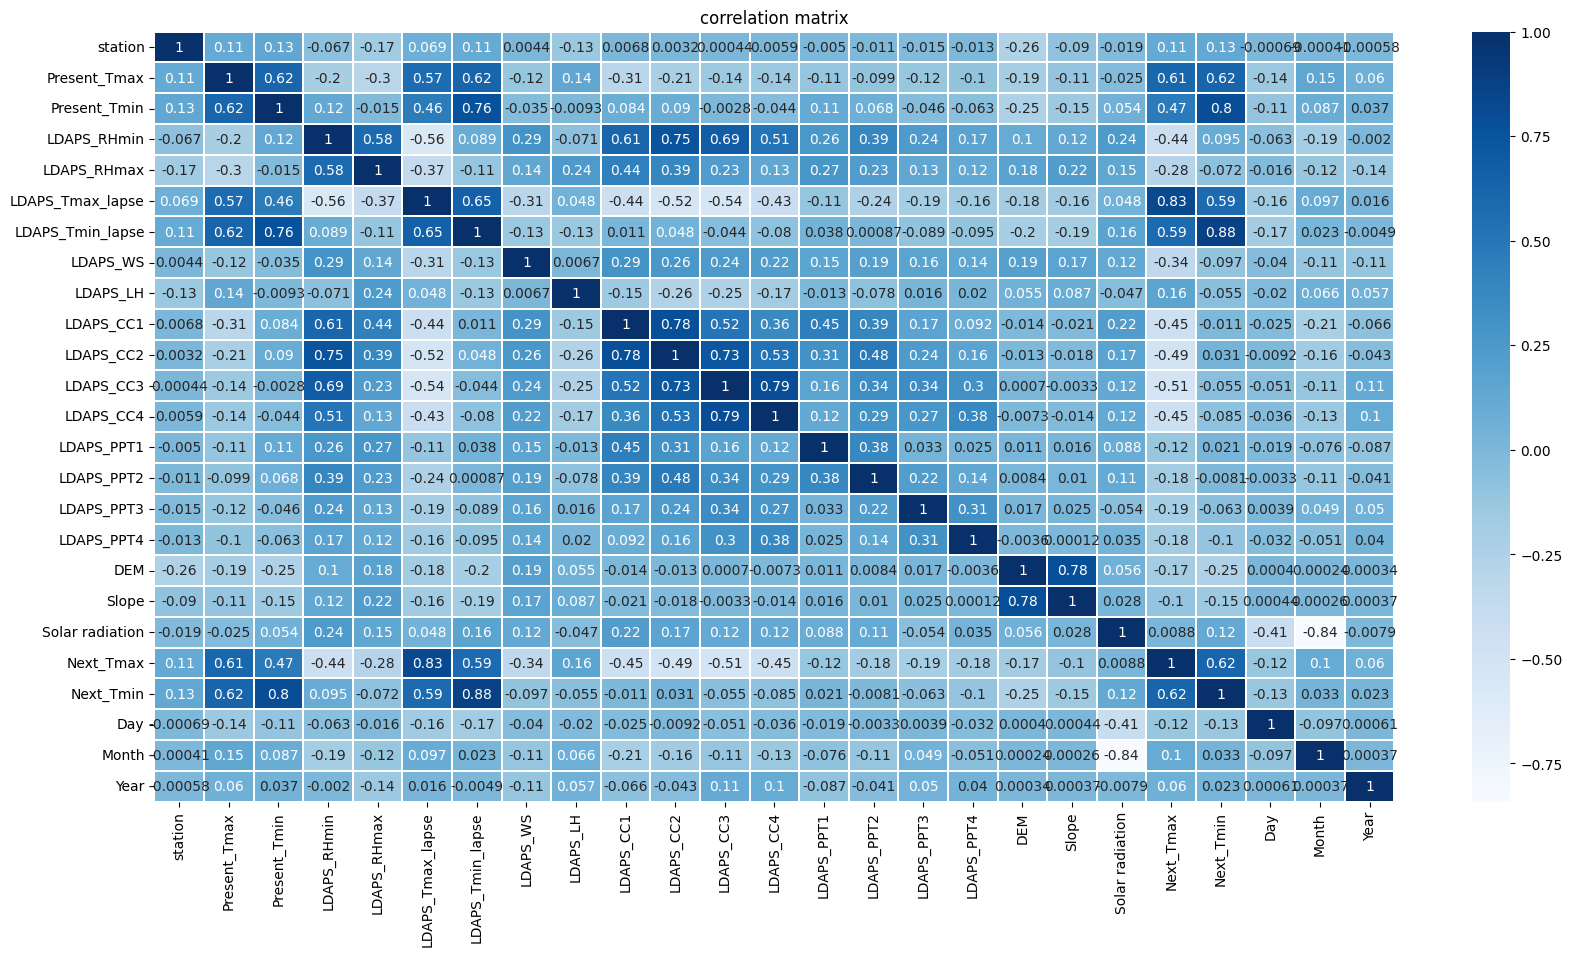

In [33]:
fig=plt.figure(figsize=(20,10))
hc=df.corr(method='pearson')
sns.heatmap(hc,annot=True,cmap="Blues",linewidths=.1, annot_kws={"size": 10})
plt.title("correlation matrix")
plt.show()

finding Skew

In [34]:
df.skew()

station             0.000182
Present_Tmax       -0.264137
Present_Tmin       -0.367538
LDAPS_RHmin         0.300220
LDAPS_RHmax        -0.855015
LDAPS_Tmax_lapse   -0.227880
LDAPS_Tmin_lapse   -0.581763
LDAPS_WS            1.579236
LDAPS_LH            0.673757
LDAPS_CC1           0.459458
LDAPS_CC2           0.472350
LDAPS_CC3           0.640735
LDAPS_CC4           0.666482
LDAPS_PPT1          5.393821
LDAPS_PPT2          5.775355
LDAPS_PPT3          6.457129
LDAPS_PPT4          6.825464
DEM                 1.723257
Slope               1.563020
Solar radiation    -0.511210
Next_Tmax          -0.340200
Next_Tmin          -0.404447
Day                -0.008989
Month              -0.196329
Year               -0.000365
dtype: float64

removing the skeww

In [35]:
skew=['LDAPS_RHmax','LDAPS_Tmin_lapse','LDAPS_WS','LDAPS_LH','LDAPS_CC3','LDAPS_CC4',
      'LDAPS_PPT1','LDAPS_PPT2','LDAPS_PPT3','LDAPS_PPT4','DEM','Slope','Solar radiation','Month']

In [36]:
scaler = PowerTransformer(method='yeo-johnson')

In [37]:
df[skew] = scaler.fit_transform(df[skew].values)

In [38]:
df.skew()

station             0.000182
Present_Tmax       -0.264137
Present_Tmin       -0.367538
LDAPS_RHmin         0.300220
LDAPS_RHmax        -0.115143
LDAPS_Tmax_lapse   -0.227880
LDAPS_Tmin_lapse   -0.017827
LDAPS_WS            0.002408
LDAPS_LH            0.057403
LDAPS_CC1           0.459458
LDAPS_CC2           0.472350
LDAPS_CC3           0.087933
LDAPS_CC4           0.126895
LDAPS_PPT1          1.404189
LDAPS_PPT2          1.577808
LDAPS_PPT3          1.747820
LDAPS_PPT4          1.963848
DEM                 0.039456
Slope               0.233968
Solar radiation    -0.176636
Next_Tmax          -0.340200
Next_Tmin          -0.404447
Day                -0.008989
Month              -0.092575
Year               -0.000365
dtype: float64

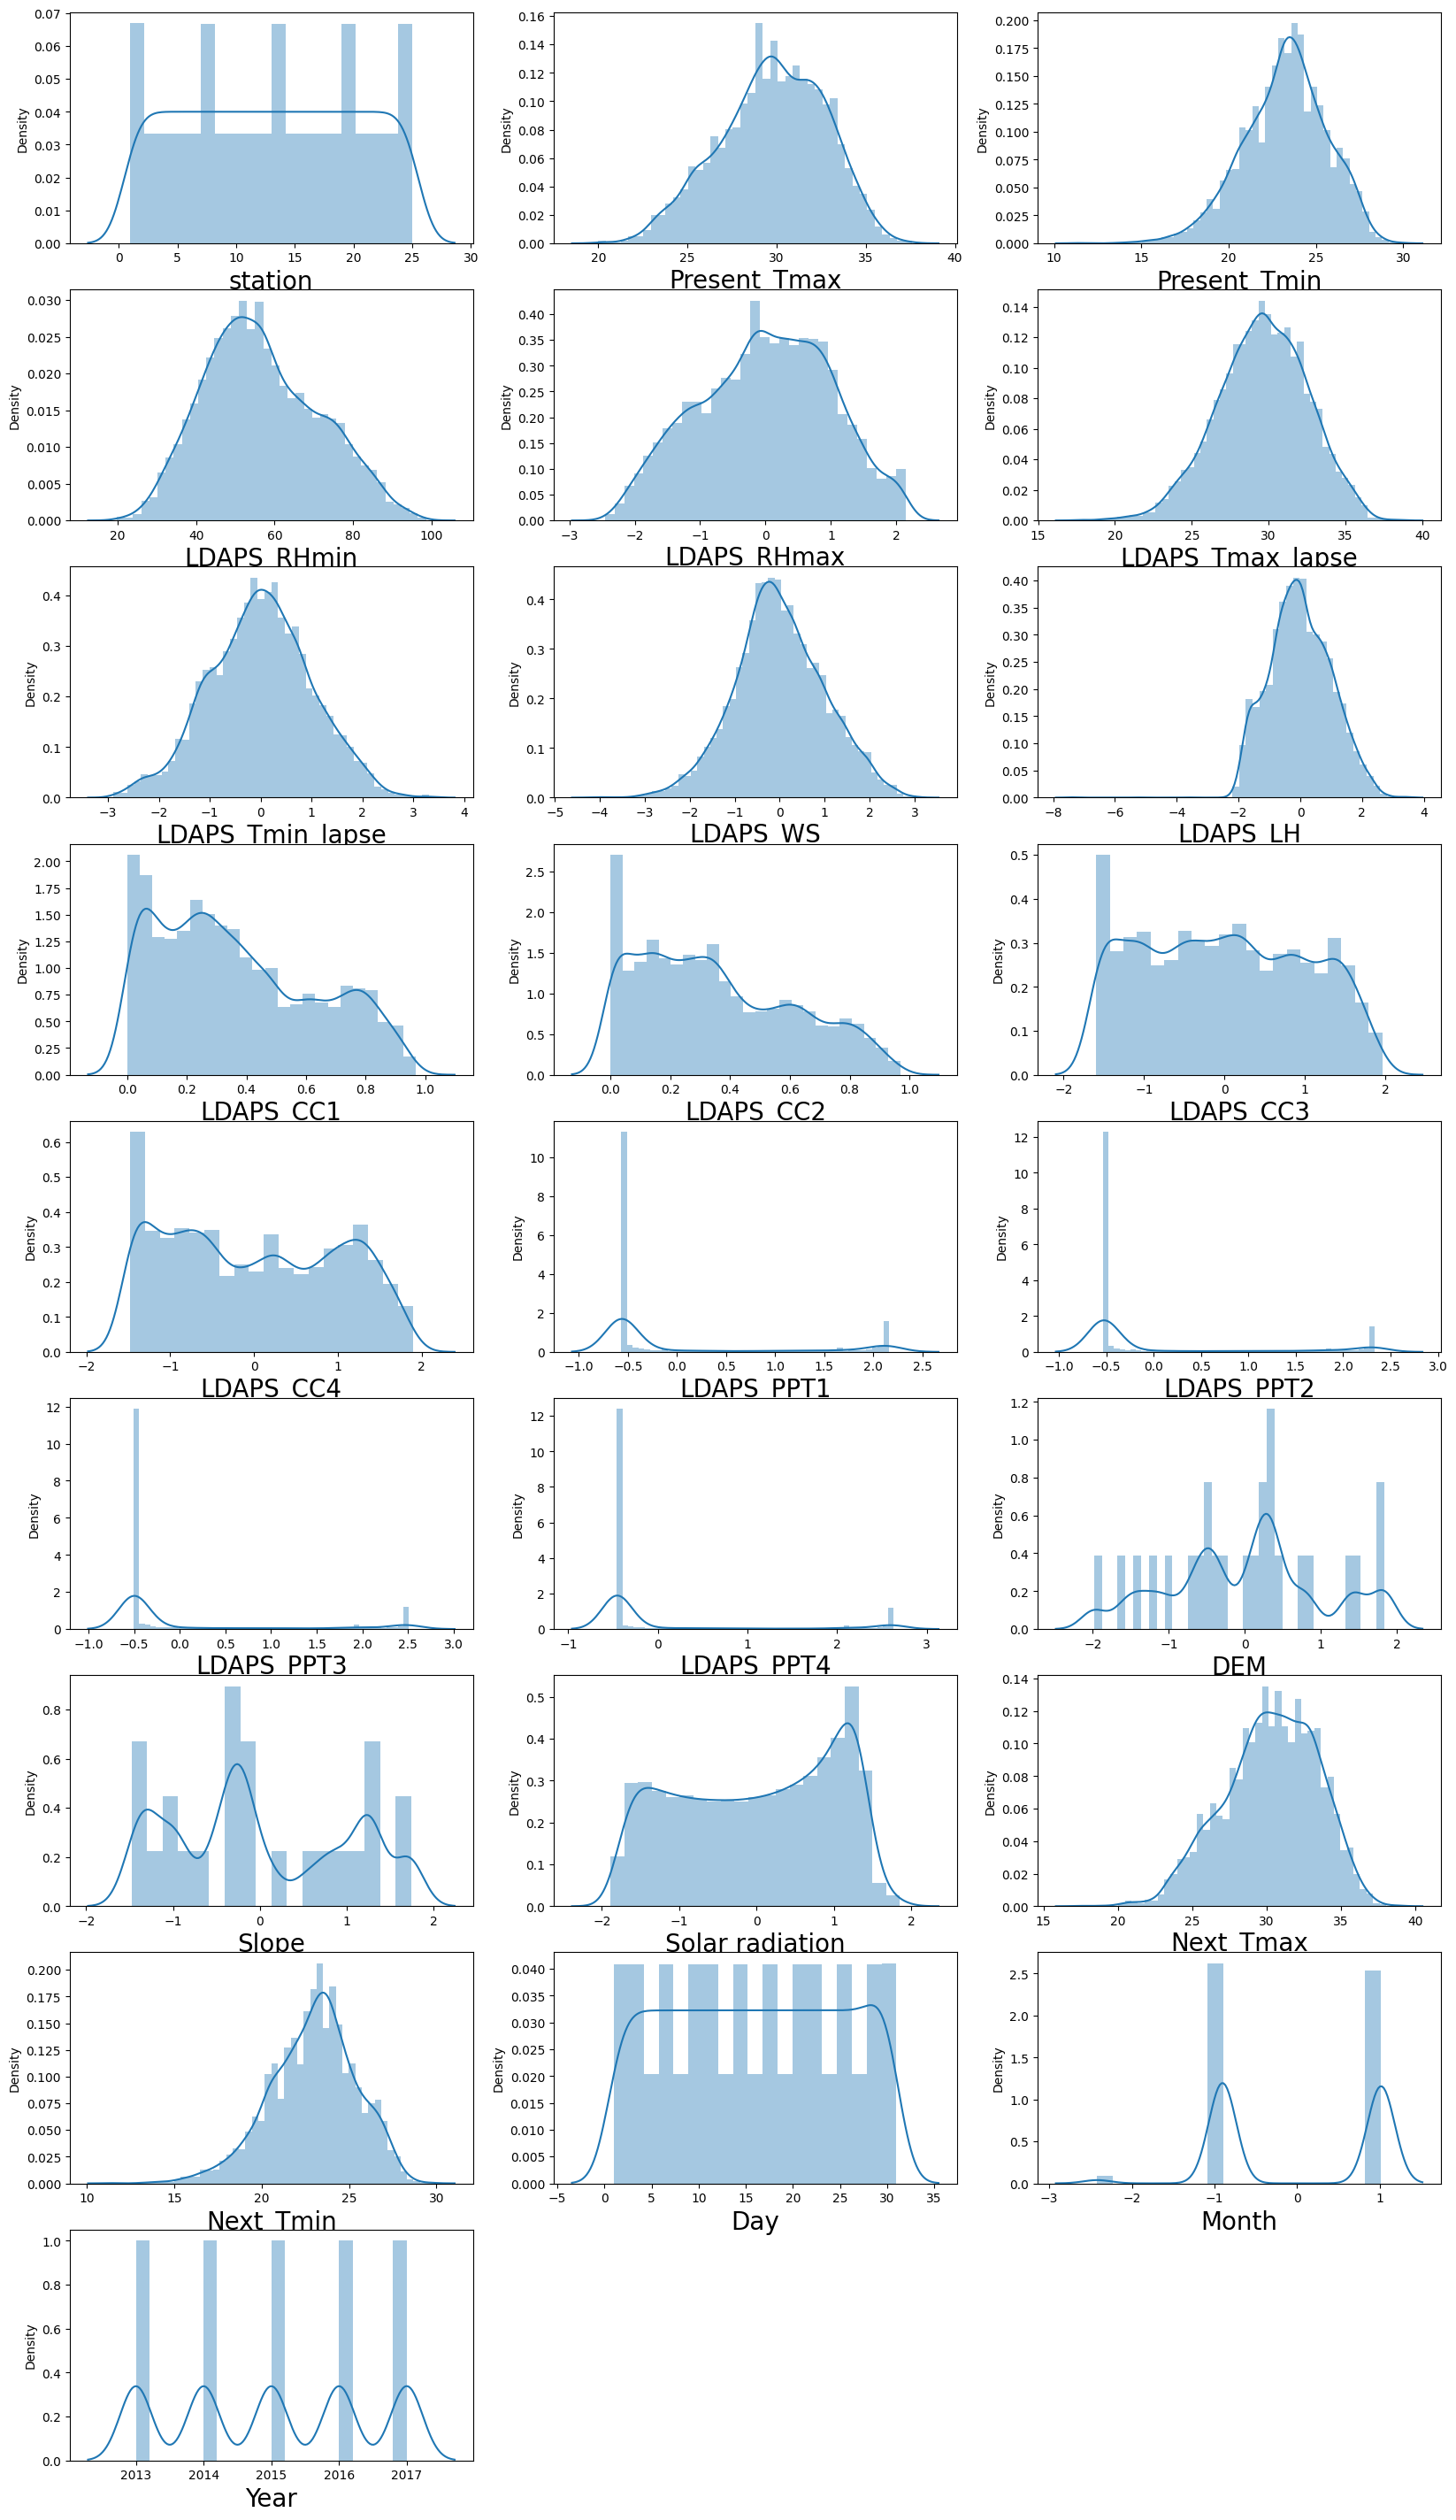

In [39]:
plt.figure(figsize=(20,40),facecolor='white')
plotnum=1
for col in df:
    if plotnum<=29:
        plt.subplot(10,3,plotnum)
        sns.distplot(df[col])
        plt.xlabel(col,fontsize=20)
    plotnum+=1
plt.show()

Finding the outliers

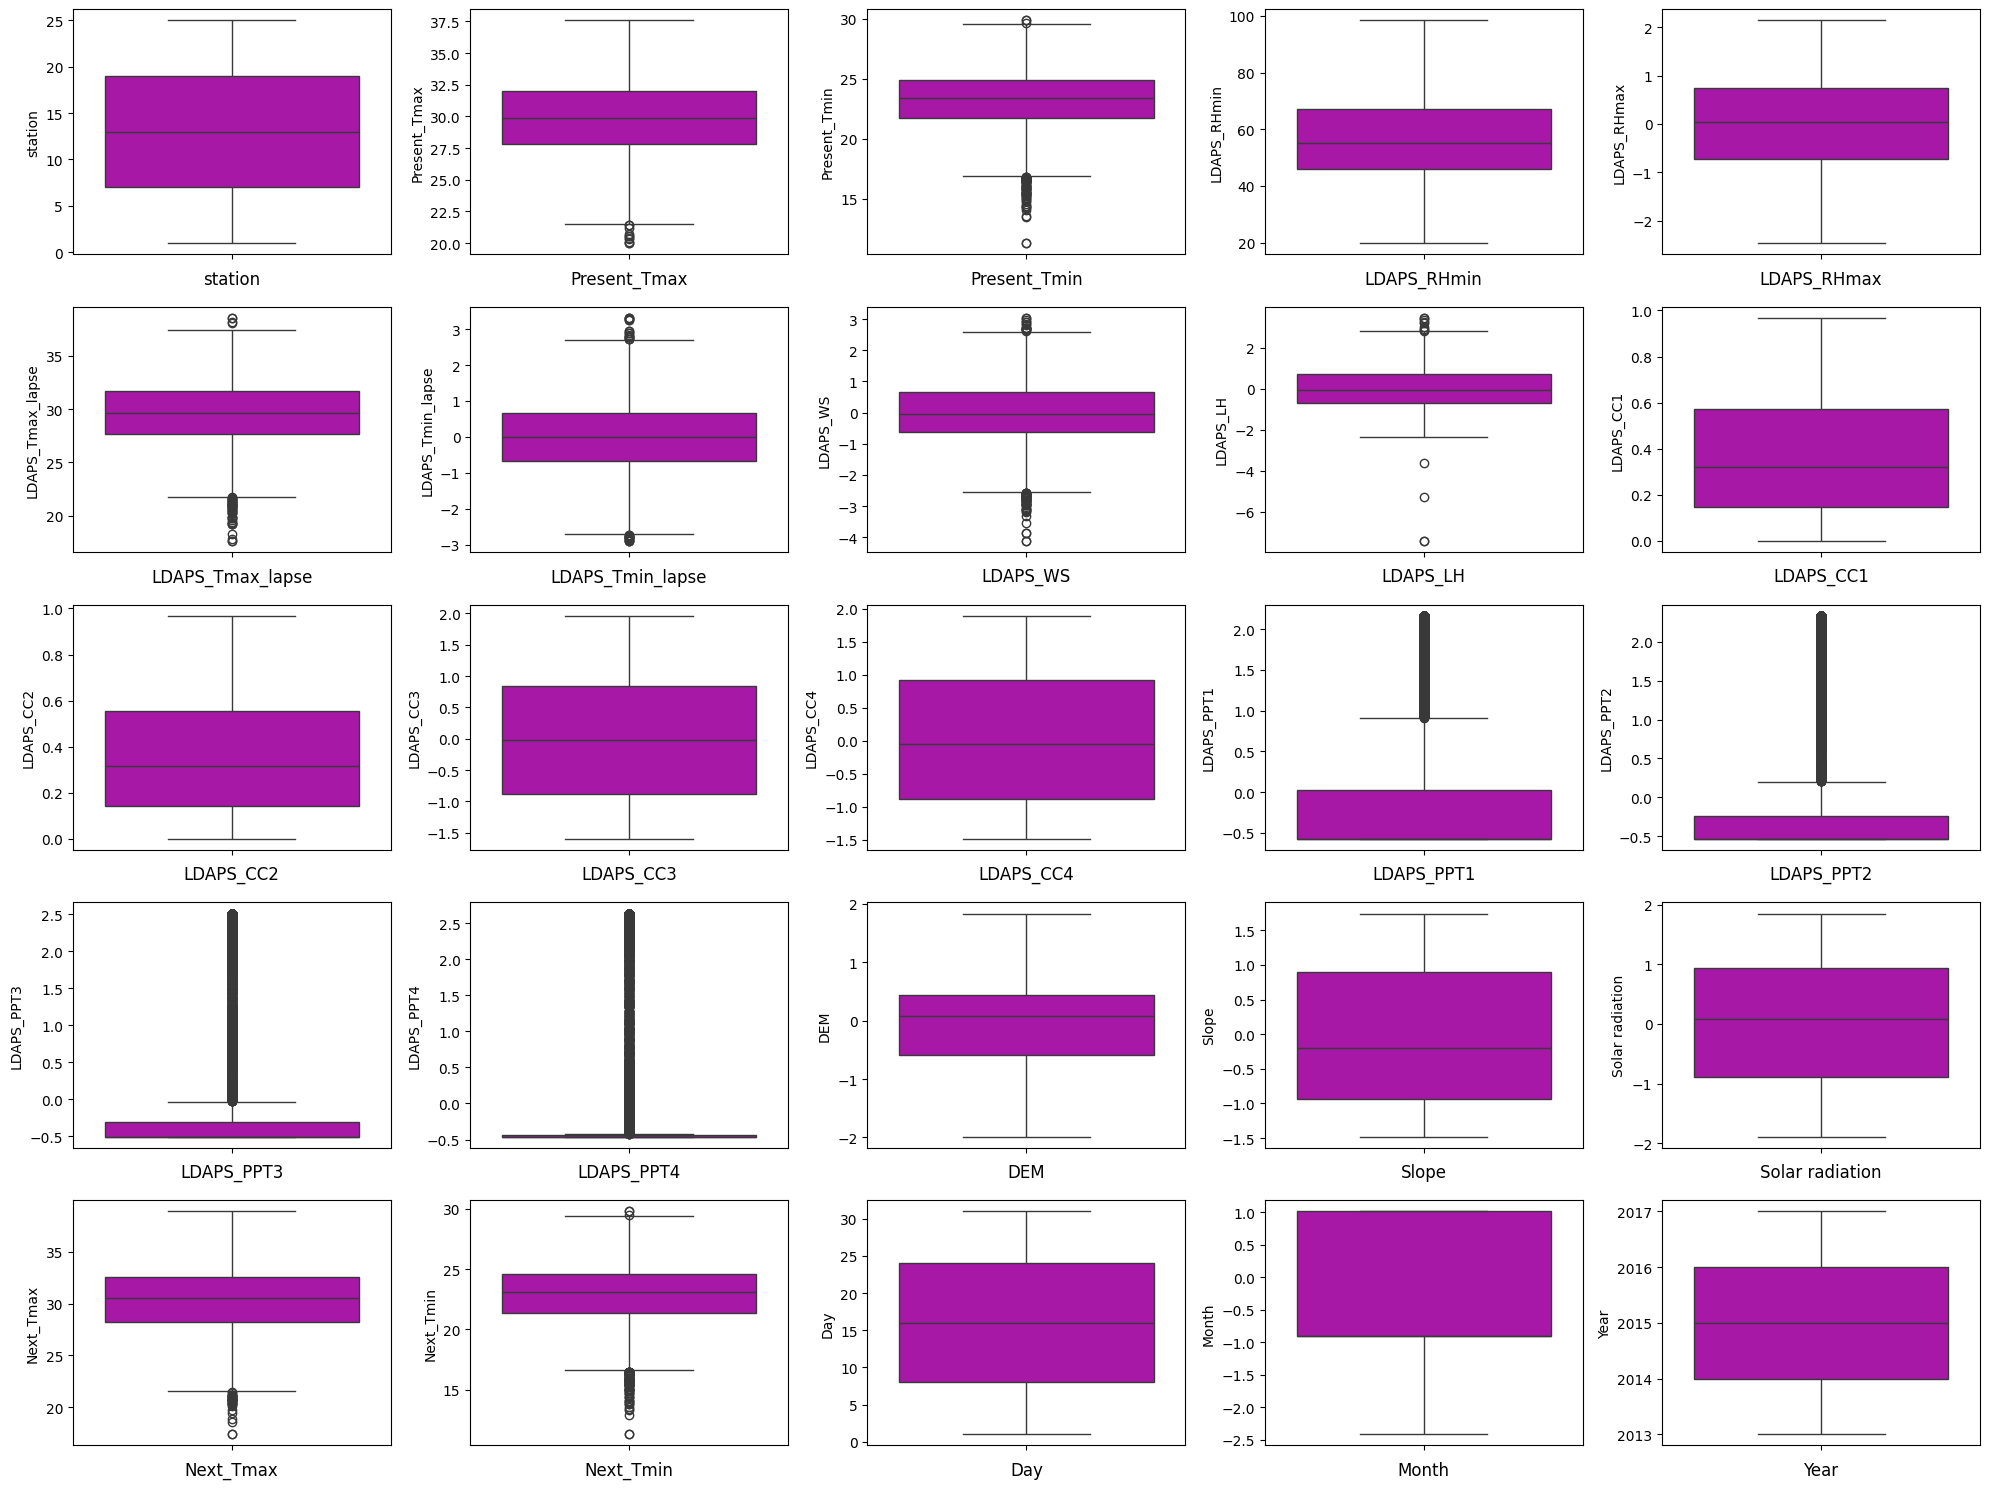

In [40]:
plt.figure(figsize=(20,15),facecolor="white")
pltno=1
for i in df:
    if pltno<=25:
        plt.subplot(5,5,pltno)
        sns.boxplot(df[i],color="m")
        plt.xlabel(i,fontsize=12)
    pltno+=1
plt.tight_layout()

OUTLIER REMOVAL

In [50]:
# METHOD 1
z=np.abs(zscore(df))
threshold=3
df1=df[(z<3).all(axis=1)]

In [51]:
df1.shape

(7642, 25)

In [52]:
print("data loss ",((df.shape[0]-df1.shape[0])/df.shape[0])*100)

data loss  1.4189886480908152


In [53]:
# METHOD 2
q1=df.quantile(.25)
q3=df.quantile(.75)
iqr=q3-q1
df2=df[~((df<(q1-1.5*iqr)) | (df>(q3+1.5*iqr))).any(axis=1)]

In [54]:
df2.shape

(4112, 25)

In [55]:
df=df1


Heatmap for checking correlation

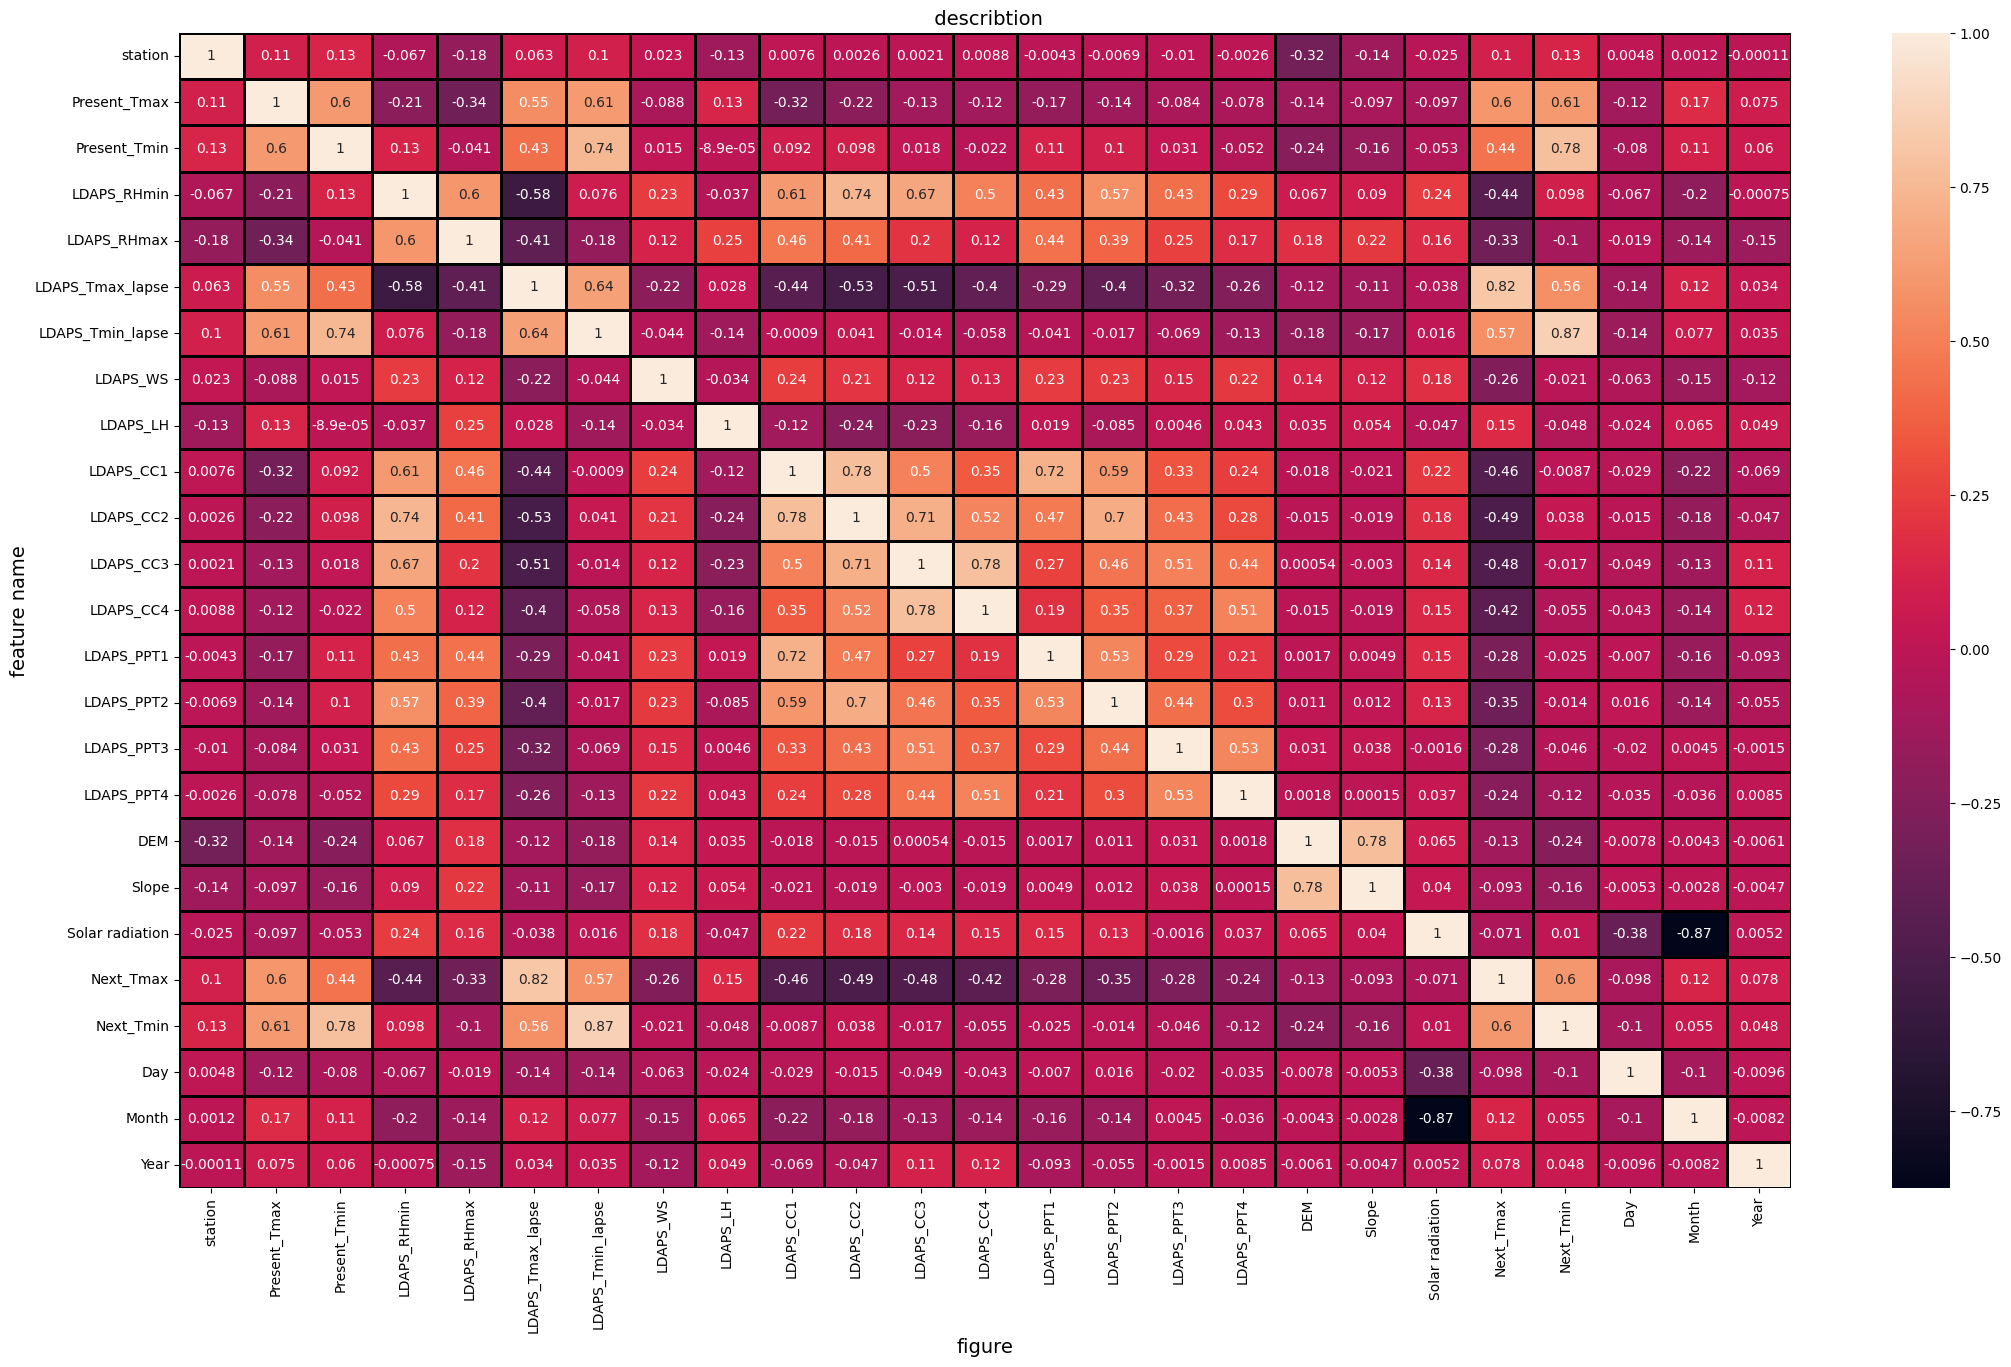

In [56]:
plt.figure(figsize = (26, 15))
sns.heatmap(df.corr(),linewidths=0.8,fmt='.2g',linecolor="black",annot=True)
plt.xlabel('figure',fontsize=14)
plt.ylabel("feature name",fontsize=14)
plt.title(" describtion",fontsize=14)
plt.show()

# target  :'Next_Tmax

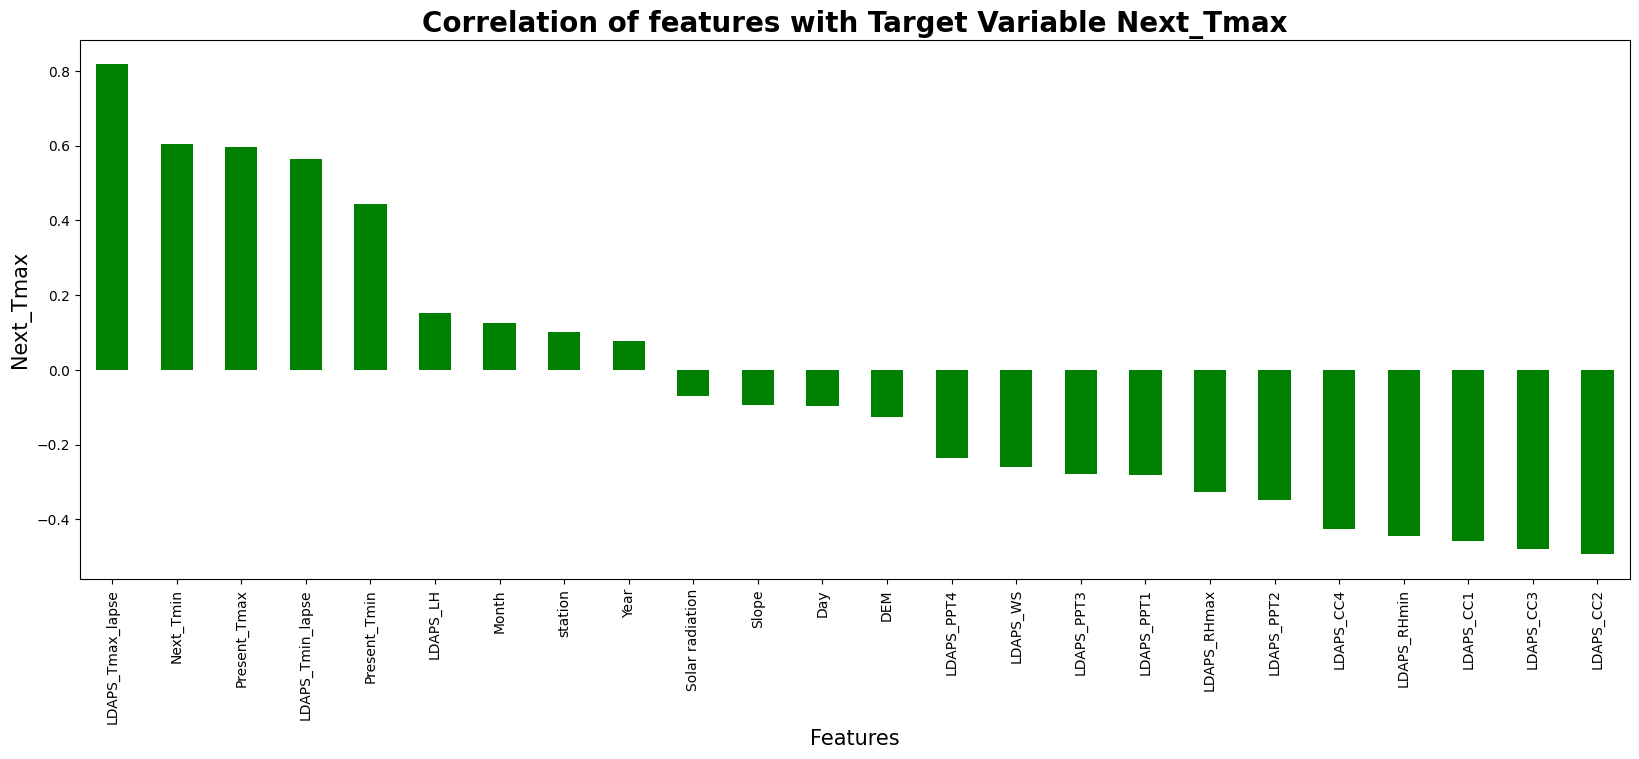

In [57]:
plt.figure(figsize = (20,7))
df.corr()['Next_Tmax'].drop(['Next_Tmax']).sort_values(ascending=False).plot(kind='bar',color = 'green')
plt.xlabel('Features',fontsize=15)
plt.ylabel('Next_Tmax',fontsize=15)
plt.title('Correlation of features with Target Variable Next_Tmax',fontsize = 20,fontweight='bold')
plt.show()

splitting data into train and test data

In [58]:
x = df.drop(['Next_Tmax'], axis =1)
y = df['Next_Tmax']

In [59]:
print(x.shape, y.shape)

(7642, 24) (7642,)


Scaling the train features

In [60]:
scaler= StandardScaler()
x= scaler.fit_transform(x)

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state = 42)

# Model buidling

Model with LinearRegression

In [62]:
maxacc=0
maxrs=0
for i in range(1,200):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=i  )
    lr=LinearRegression()
    lr.fit(x_train,y_train)
    pred=lr.predict(x_test)
    acc=r2_score(y_test,pred)
    if acc>maxacc:
        maxacc=acc
        maxrs=i
print(" max r2 score : ",maxacc," on random state ", maxrs)



 max r2 score :  0.7995304696634769  on random state  30


In [63]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=maxrs   )

In [64]:
LR=LinearRegression()
LR.fit(x_train,y_train)
pred_LR=LR.predict(x_test)
pred_train=LR.predict(x_train)
print("r2 score :", r2_score(y_test,pred_LR))
print(" r2 score on training data :",r2_score(y_train,pred_train)*100)
print(" MAE : ",mean_absolute_error(y_test,pred_LR))
print(" MSE :",mean_squared_error(y_test,pred_LR))
print("rmse :",np.sqrt(mean_squared_error(y_test,pred_LR)))

r2 score : 0.7995304696634769
 r2 score on training data : 77.46459693516583
 MAE :  1.0598282651656261
 MSE : 1.9213948953889577
rmse : 1.3861438941859383


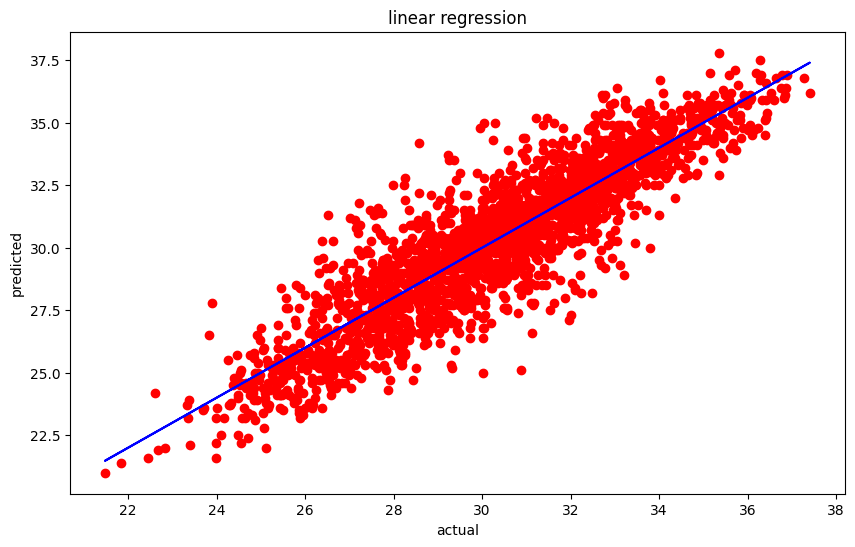

In [65]:
plt.figure(figsize=(10,6))
plt.scatter(x=pred_LR,y=y_test,color='r')
plt.plot(pred_LR,pred_LR,color='b')
plt.xlabel("actual")
plt.ylabel("predicted")
plt.title("linear regression")
plt.show()

In [66]:
model={'dt':DecisionTreeRegressor(),'rf':RandomForestRegressor(),'lR': LinearRegression(),
       'svr': SVR(),'knn':KNeighborsRegressor(),'rid':Ridge(),'ls':Lasso(),'gb':GradientBoostingRegressor(),'et':ExtraTreesRegressor(),}     
print(model)

{'dt': DecisionTreeRegressor(), 'rf': RandomForestRegressor(), 'lR': LinearRegression(), 'svr': SVR(), 'knn': KNeighborsRegressor(), 'rid': Ridge(), 'ls': Lasso(), 'gb': GradientBoostingRegressor(), 'et': ExtraTreesRegressor()}


In [67]:
y_preds = {}
for key, value in model.items():
    value.fit(x_train, y_train)
    y_pred = value.predict(x_test)
    y_preds[key] = y_pred
y_pred

array([25.616     , 26.486     , 31.984     , ..., 28.22274887,
       30.822     , 28.601     ])

In [68]:
value.score(x_train,y_train)

1.0

In [69]:
value.score(x_test,y_test)

0.9359989736907424

In [70]:
mae = {}
mse = {}
r2 = {}
rmse = {}

for key, value in model.items():
    y_pred = value.predict(x_test)
    
    mae[key] = mean_absolute_error(y_test, y_pred)
    mse[key] = mean_squared_error(y_test, y_pred)
    r2[key] = r2_score(y_test, y_pred)
    rmse[key] = np.sqrt(mse[key])

details = pd.DataFrame({
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
})

print("\nDetails for each model:")
print(details)



Details for each model:
          MAE       MSE      RMSE        R2
dt   1.012865  2.038276  1.427682  0.787336
rf   0.679631  0.822096  0.906695  0.914226
lR   1.059828  1.921395  1.386144  0.799530
svr  0.718482  0.918617  0.958445  0.904156
knn  0.714222  0.916817  0.957506  0.904344
rid  1.059864  1.921384  1.386140  0.799532
ls   1.627780  4.086832  2.021591  0.573599
gb   0.858608  1.260170  1.122573  0.868520
et   0.581567  0.613416  0.783209  0.935999


Great we got least difference e in case of ExtraTreesRegressor algorithm, hence I am selecting it as our best suitable algorithm for final model.

check results of our final model with best parameters

In [71]:
model_1 = ExtraTreesRegressor(max_depth = 20, n_estimators = 500, min_samples_split = 2)
model_1.fit(x_train,y_train)
y_pred = model_1.predict(x_train)
pred = model_1.predict(x_test)

mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,pred)
print("MAE :", mae)
print('MAE :',mse )
print("RMSE :", rmse)

print("\nTraining r2 Score :", r2_score(y_train,y_pred)*100,'%')
print(f"\nTesting r2 Score: {r2_score(y_test,pred)*100}%")

MAE : 0.5802075153252009
MAE : 0.6137989522624051
RMSE : 0.7834532227659831

Training r2 Score : 99.98320845083336 %

Testing r2 Score: 93.59590326921395%


Y Test       Pred
327     25.5  25.619390
330     26.5  26.422614
492     33.0  31.796227
4750    23.2  23.636550
6128    25.9  25.562450

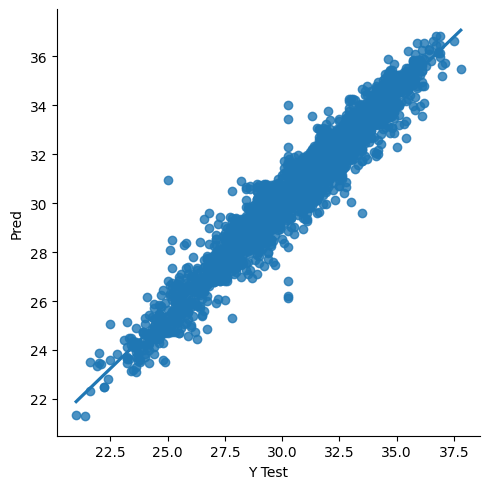

In [72]:
data = pd.DataFrame({'Y Test':y_test , 'Pred':pred},columns=['Y Test','Pred'])
sns.lmplot(x='Y Test',y='Pred',data=data,palette='rainbow')
data.head()

In [ ]:
import joblib
joblib.dump(model_1,"Next_Tmax_prediction.pkl")

# Target : Next_Tmin

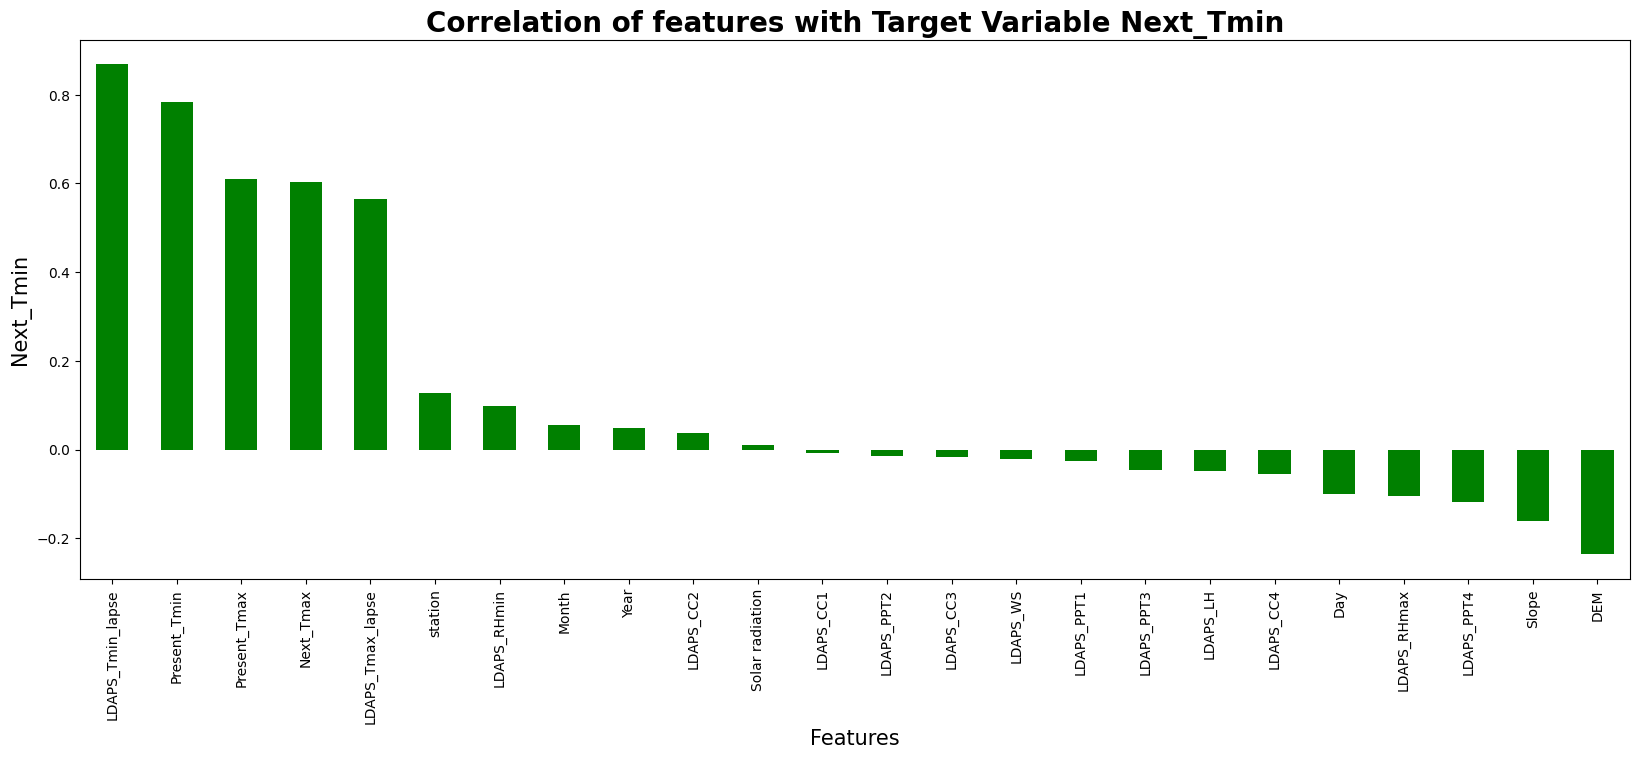

In [73]:
plt.figure(figsize = (20,7))
df.corr()['Next_Tmin'].drop(['Next_Tmin']).sort_values(ascending=False).plot(kind='bar',color = 'green')
plt.xlabel('Features',fontsize=15)
plt.ylabel('Next_Tmin',fontsize=15)
plt.title('Correlation of features with Target Variable Next_Tmin',fontsize = 20,fontweight='bold')
plt.show()

In [74]:
x = df.drop(['Next_Tmin'], axis =1)
y = df['Next_Tmin']

In [75]:
scaler= StandardScaler()
x= scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state = 42)

MODEL BUILDING

In [76]:
y_preds = {}
for key, value in model.items():
    value.fit(x_train, y_train)
    y_pred = value.predict(x_test)
    y_preds[key] = y_pred
y_pred

array([22.365    , 23.8162888, 22.505    , ..., 25.242    , 25.8      ,
       19.181    ])

In [77]:
value.score(x_train,y_train)

1.0

In [78]:
value.score(x_test,y_test)

0.9133269096011778

In [79]:
mae = {}
mse = {}
r2 = {}
rmse = {}

for key, value in model.items():
    y_pred = value.predict(x_test)
    
    mae[key] = mean_absolute_error(y_test, y_pred)
    mse[key] = mean_squared_error(y_test, y_pred)
    r2[key] = r2_score(y_test, y_pred)
    rmse[key] = np.sqrt(mse[key])

details = pd.DataFrame({
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
})

print("\nDetails for each model:")
print(details)



Details for each model:
          MAE       MSE      RMSE        R2
dt   0.786379  1.108516  1.052861  0.801265
rf   0.554388  0.536899  0.732734  0.903744
lR   0.761764  0.910763  0.954339  0.836718
svr  0.527143  0.474607  0.688917  0.914912
knn  0.651613  0.719320  0.848127  0.871040
rid  0.761782  0.910769  0.954342  0.836717
ls   1.201616  2.250244  1.500081  0.596575
gb   0.617010  0.620262  0.787567  0.888799
et   0.523764  0.483449  0.695305  0.913327


In [80]:
model_1 = ExtraTreesRegressor(max_depth = 20, n_estimators = 500, min_samples_split = 2)
model_1.fit(x_train,y_train)
y_pred = model_1.predict(x_train)
pred = model_1.predict(x_test)

mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,pred)
print("MAE :", mae)
print('MAE :',mse )
print("RMSE :", rmse)

print("\nTraining r2 Score :", r2_score(y_train,y_pred)*100,'%')
print(f"\nTesting r2 Score: {r2_score(y_test,pred)*100}%")

MAE : 0.5155601298197565
MAE : 0.46895178298314427
RMSE : 0.6848005424816369

Training r2 Score : 99.9791971632861 %

Testing r2 Score: 91.59260605629956%


Y Test       Pred
7587    22.1  22.258339
7562    24.6  23.912686
2469    22.4  22.454512
4534    17.9  19.353464
2987    21.2  20.142985

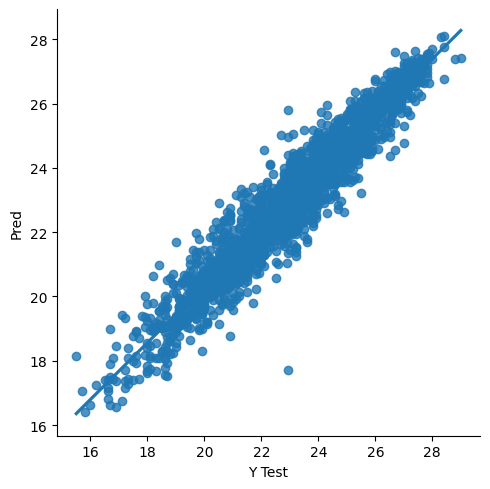

In [81]:
data = pd.DataFrame({'Y Test':y_test , 'Pred':pred},columns=['Y Test','Pred'])
sns.lmplot(x='Y Test',y='Pred',data=data,palette='rainbow')
data.head()

In [ ]:
import joblib
joblib.dump(model_1,"Next_Tmin_prediction.pkl")